In [320]:
# importing the necessary packages

import dash
import dash_html_components as html
import dash_core_components as dcc
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import pandas as pd
import numpy as np
from scipy import stats
import functools
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode()
import matplotlib.pyplot as plt

%matplotlib notebook

## Loading all the csv data files

In [161]:
baseline_df = pd.read_csv(r'baseline.csv')
procedure_df = pd.read_csv(r'procedure.csv')
outcomes_df = pd.read_csv(r'outcomes.csv')
hemodynamics_df = pd.read_csv(r'hemodynamics.csv')

# Finding insights from the data 

## 1. Are there any associations between clot location and procedural characteristics?

In [162]:
#Merging the Baseline and procedure dataframes on the primary key - SubjectID

base_proc_df = pd.merge(baseline_df,procedure_df, how='inner', on='SUBJECTID')
base_proc_df.head()

SUBJECTID  site        age    bmi                            CUPE  \
0   005-016     5  65.051335  36.54  Submassive (Intermediate Risk)   
1   003-054     3  66.239562  39.00  Submassive (Intermediate Risk)   
2   006-012     6  62.417522  33.19  Submassive (Intermediate Risk)   
3   019-003    19  72.736482  25.96             Massive (High Risk)   
4   027-002    27  69.399042  41.45             Massive (High Risk)   

      location  spesi  rvlv_rat biomarkers      dyspnea lytics_contra hx_pe  \
0       saddle    2.0  1.300000        Yes            3            No    No   
1  <undefined>    NaN       NaN        Yes     Not done      Absolute    No   
2       saddle    2.0  2.910053        Yes  <undefined>            No   Yes   
3       saddle    1.0       NaN        Yes     Not done            No    No   
4    bilateral    2.0  1.864238        Yes            4            No    No   

  hx_dvt cur_dvt  proc_time  cath_time  fluoro_time  T20  Disks  missing  
0     No     Yes       82.0       60.0        34.55    1      0        0  
1     No      No       80.0       33.0        26.00    0      0        1  
2     No      No       99.0       89.0        20.00    0      0        1  
3     No      No        NaN       47.0        19.50    0      0        0  
4     No      No       62.0       37.0        12.80    0      0        0

In [163]:
base_proc_df.describe().transpose()

count       mean        std          min        25%        50%  \
site         325.0  10.901538   8.903261     1.000000   5.000000   7.000000   
age          324.0  61.257383  14.066027    19.307324  51.808350  63.180014   
bmi          322.0  34.772547   8.481793    19.000000  28.530000  33.080000   
spesi        298.0   1.583893   1.032148     0.000000   1.000000   2.000000   
rvlv_rat     300.0   1.545416   0.504725     0.346154   1.211168   1.438999   
proc_time    296.0  76.831081  32.593623    18.000000  55.000000  72.000000   
cath_time    298.0  44.208054  84.874459 -1335.000000  30.000000  44.000000   
fluoro_time  314.0  24.117675  11.144898     4.500000  16.000000  21.765000   
T20          325.0   0.430769   0.495947     0.000000   0.000000   0.000000   
Disks        325.0   0.098462   0.298397     0.000000   0.000000   0.000000   
missing      325.0   0.387692   0.487975     0.000000   0.000000   0.000000   

                   75%         max  
site         15.000000   42.000000  
age          71.383984   89.793292  
bmi          39.460000   65.530000  
spesi         2.000000    5.000000  
rvlv_rat      1.744565    4.448000  
proc_time    91.000000  237.000000  
cath_time    61.000000  175.000000  
fluoro_time  30.675000   72.100000  
T20           1.000000    1.000000  
Disks         0.000000    1.000000  
missing       1.000000    1.000000

In [164]:
# Removing rows with no clot location information

base_proc_df.drop(base_proc_df[base_proc_df['location'] == '<undefined>'].index, axis=0, inplace=True)
base_proc_df.drop(base_proc_df[base_proc_df['location'].isna()].index, axis=0, inplace=True)

In [165]:
# Creating a dataframe with just the necessary columns

clot_cath_df = base_proc_df[['location','T20','missing','Disks']]

#### Patients per Clot Location

In [166]:
clot_cath_df1 = clot_cath_df['location'].value_counts()
clot_cath_df2 = (clot_cath_df['location'].value_counts(normalize = True)*100).round(2)

In [167]:
cath_loc_df1 = pd.DataFrame({'Number of occurences':clot_cath_df1,'Percentage':clot_cath_df2})

In [168]:
cath_loc_df1 = cath_loc_df1.reset_index()
cath_loc_df1 = cath_loc_df1.rename(columns={'index':'Location'})

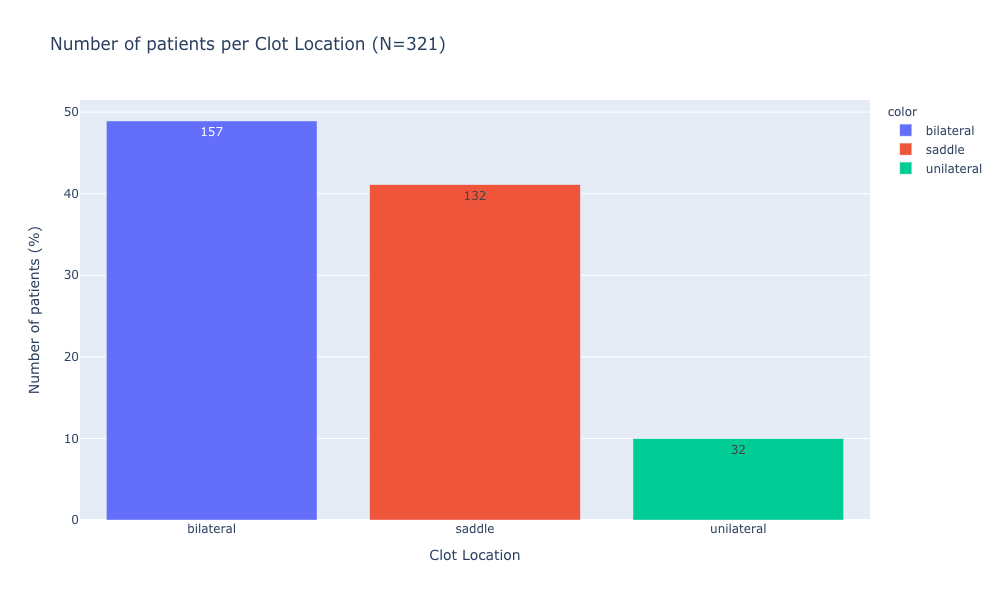

In [377]:
fig1 = px.bar(x=cath_loc_df1.Location,y=cath_loc_df1['Percentage'],color=cath_loc_df1.Location,text=cath_loc_df1['Number of occurences'],
      title='Number of patients per Clot Location (N=321)',labels={'x':'Clot Location','y':'Number of patients (%)'},
              width=1000, height=600)

# show the image
fig1.show(renderer='png', width=1000, height=600)

### Clot Location vs Catheter Used
#### Using the information from the table to find where T24 aspiration catheter was used
##### T24 is used when T20 == 0 and missing == 0 

In [170]:
# Creating a new T24 column where T24==1 and T24==0 means that the catheter was used and not used respectively

clot_cath_df['T24'] = np.where(((clot_cath_df['T20'] == 0) & (clot_cath_df['missing'] == 0)),1,0)

#### Consolidating multiple columns into one column to understand what catheter was used on which patient 

In [171]:
# Creating a new catheter column
clot_cath_df['Catheter'] = clot_cath_df['T20']

In [172]:
clot_cath_df['Catheter'].loc[(clot_cath_df['T20'] == 1) & (clot_cath_df['Disks'] == 0)] = 'T20'
clot_cath_df['Catheter'].loc[(clot_cath_df['T20'] == 1) & (clot_cath_df['Disks'] == 1)] = 'T20 and Disks'
clot_cath_df['Catheter'].loc[(clot_cath_df['T24'] == 1) & (clot_cath_df['Disks'] == 0)] = 'T24'
clot_cath_df['Catheter'].loc[(clot_cath_df['T24'] == 1) & (clot_cath_df['Disks'] == 1)] = 'T24 and Disks'

#### Removing all the rows where missing == 1 , missing, and other catheter information columns

In [173]:
clot_cath_df = clot_cath_df[clot_cath_df['missing']==0].drop(['missing', 'T20','Disks','T24'],axis=1)

#### Catheter Usage with respect to Clot location 

In [174]:
clot_cath_df1 = clot_cath_df[['location','Catheter']].value_counts()
clot_cath_df1 = clot_cath_df1.reset_index()
clot_cath_df1.columns =  ['Location', 'Catheter','Number of patients']

In [175]:
clot_cath_df1['Catheter_sum'] = clot_cath_df1['Number of patients']

In [176]:
clot_cath_df1['Catheter_sum'].loc[(clot_cath_df1['Location'] == 'bilateral')] = 90
clot_cath_df1['Catheter_sum'].loc[(clot_cath_df1['Location'] == 'saddle')] = 86
clot_cath_df1['Catheter_sum'].loc[(clot_cath_df1['Location'] == 'unilateral')] = 19

In [177]:
clot_cath_df1['Percentage'] = (clot_cath_df1['Number of patients']/clot_cath_df1['Catheter_sum']*100).round(2)

In [178]:
clot_cath_df1 = clot_cath_df1.drop(['Catheter_sum'],axis=1)

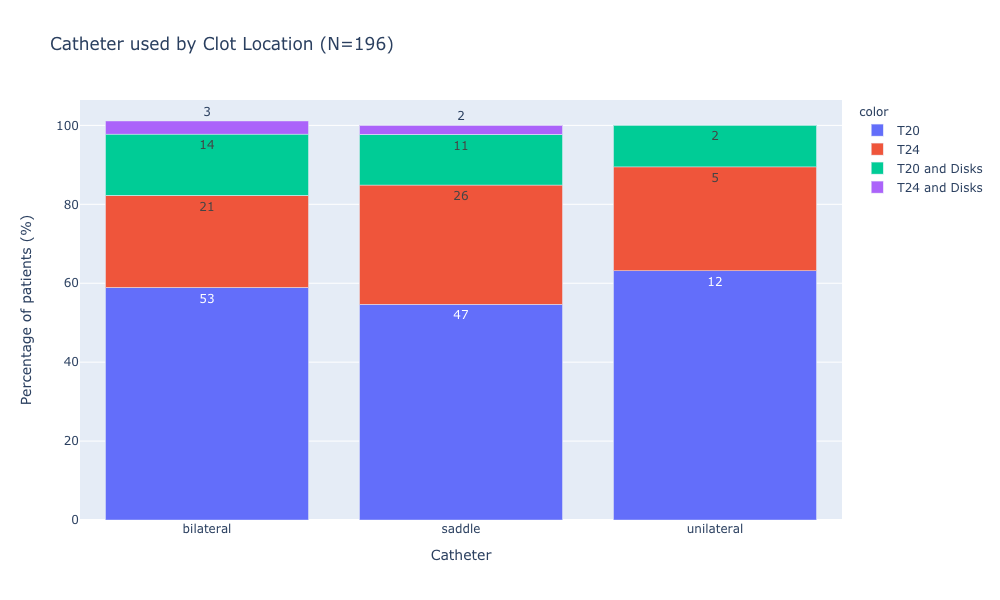

In [376]:
fig2 = px.bar(x=clot_cath_df1.Location,y=clot_cath_df1['Percentage'],color=clot_cath_df1['Catheter'],
              text=clot_cath_df1['Number of patients'],
      title='Catheter used by Clot Location (N=196)',labels={'x':'Catheter','y':'Percentage of patients (%)'},
             width=1000, height=600)

fig2.show(renderer='png', width=1000, height=600)

### Clot location vs time taken to perform the clot removal - procedure, cath and fluoro times

In [180]:
# Removing the row with negative cath_time because it is not possible. The row also had too many missing values

base_proc_df = base_proc_df.drop(base_proc_df[base_proc_df['cath_time'] <0].index, axis=0)

In [181]:
# Creating a dataframe with clot location and clot removal times information
clot_times_df = base_proc_df[['location','proc_time','cath_time','fluoro_time']]
clot_times_df.head()

location  proc_time  cath_time  fluoro_time
0     saddle       82.0       60.0        34.55
2     saddle       99.0       89.0        20.00
3     saddle        NaN       47.0        19.50
4  bilateral       62.0       37.0        12.80
5     saddle        NaN        NaN        28.80

In [182]:
# Summary of procedure time
clot_times_df.describe()

proc_time   cath_time  fluoro_time
count  294.000000  296.000000   311.000000
mean    76.724490   48.905405    24.049035
std     32.662546   27.959981    11.168777
min     18.000000    5.000000     4.500000
25%     55.000000   30.000000    15.900000
50%     71.500000   44.500000    21.700000
75%     91.000000   61.000000    30.300000
max    237.000000  175.000000    72.100000

In [183]:
#Removing rows all times values missing

missing_times_rows = list(clot_times_df[clot_times_df.isnull().sum(axis=1) >= 3].index)
clot_times_df.drop(missing_times_rows, inplace=True)

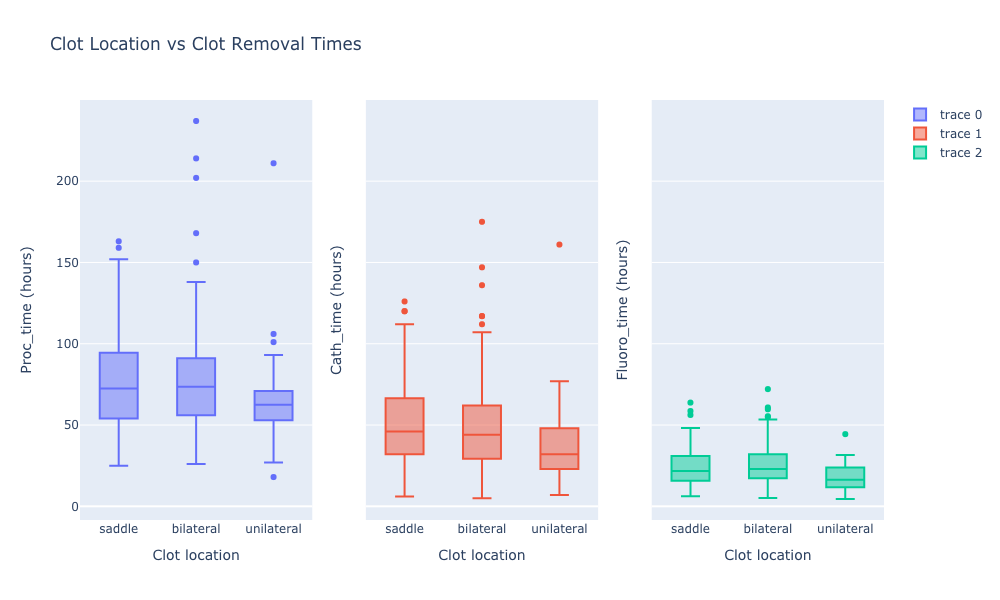

In [375]:
#Box plots of Clot location vs Clot Removal Times
subfig1 = make_subplots(rows=1, cols=3,shared_yaxes=True)
subfig1.add_box(row=1, col=1,y=clot_times_df['proc_time'],x=clot_times_df['location'])
subfig1.add_box(row=1, col=2,y=clot_times_df['cath_time'],x=clot_times_df['location'])
subfig1.add_box(row=1, col=3,y=clot_times_df['fluoro_time'],x=clot_times_df['location'])

# Update xaxis properties
subfig1.update_xaxes(title_text="Clot location", row=1, col=1)
subfig1.update_xaxes(title_text="Clot location", row=1, col=2)
subfig1.update_xaxes(title_text="Clot location", row=1, col=3)


# Update yaxis properties
subfig1.update_yaxes(title_text="Proc_time (hours)", row=1, col=1)
subfig1.update_yaxes(title_text="Cath_time (hours)", row=1, col=2)
subfig1.update_yaxes(title_text="Fluoro_time (hours)", row=1, col=3)

subfig1.update_layout(width=1200, height=800, title_text="Clot Location vs Clot Removal Times")
subfig1.show(renderer='png', width=1000, height=600)

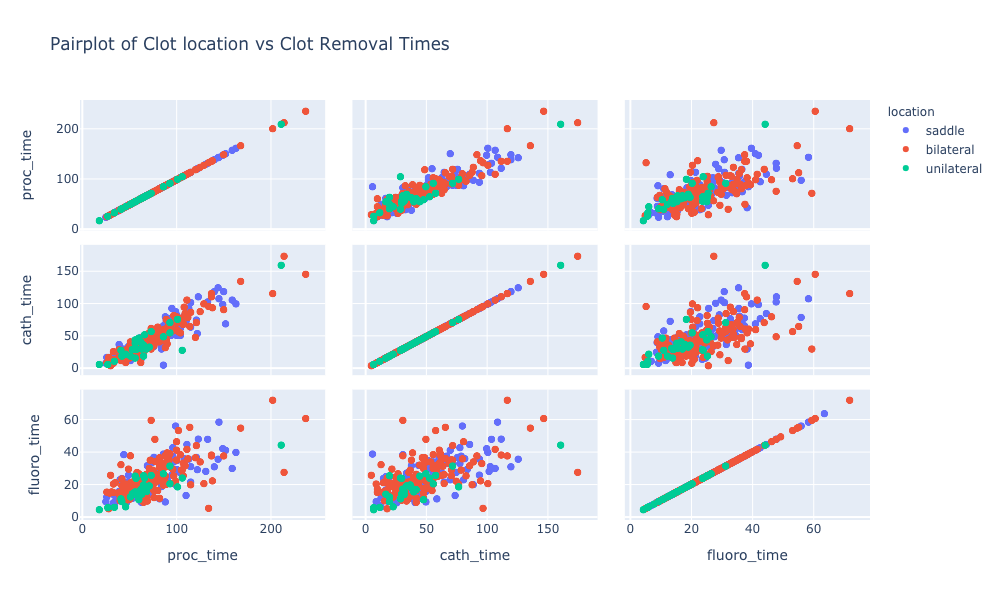

In [378]:
#Creating pairplot to see the association between different procedure times
fig3 = px.scatter_matrix(clot_times_df,dimensions=['proc_time','cath_time','fluoro_time'],color='location', title='Pairplot of Clot location vs Clot Removal Times'
                        ,width=1000, height=600)
fig3.show(renderer='png', width=1000, height=600)

#### Correlation Matrix between the Clot Removal Times

In [186]:
# changing into categorical codes - 'bilateral' - 1, 'saddle' - 2, 'unilateral' - 3

clot_times_df['clot_location'] = clot_times_df['location'].astype('category').cat.codes + 1 

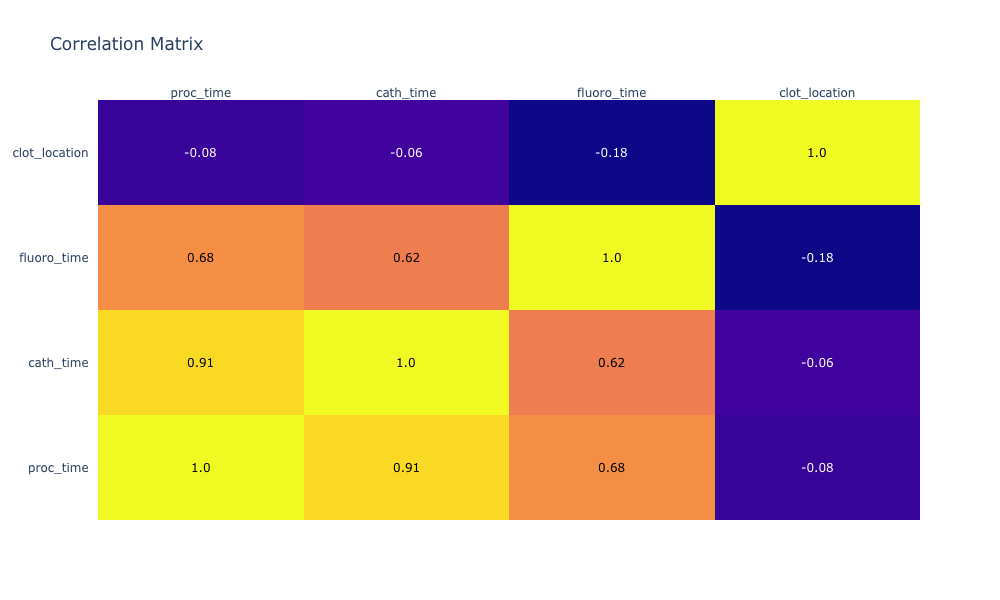

In [379]:
corr1 = clot_times_df.corr().round(2)
corr1
fig4 = ff.create_annotated_heatmap(corr1.values,x=[x for x in corr1.columns], y=[y for y in corr1.index])
fig4.update_layout(height=600, width=1000, title_text="Correlation Matrix")
fig4.show(renderer='png', width=1000, height=600)

## 2. Are any baseline or procedural characteristics associated with one another or with outcomes measures?

In [188]:
# Merging the baseline, procedure and outcomes dataframes into a single dataframe using Subject ID as the unique identifier

dfs = [baseline_df,procedure_df,outcomes_df]

df_final = functools.reduce(lambda left,right: pd.merge(left,right,on='SUBJECTID'), dfs)
pd.options.display.max_columns=60
df_final['age_bins'] = pd.cut(df_final['age'], bins = [19,29,39,49,59,69,79,89], labels = ['20s', '30s','40s', '50s','60s','70s','80s'])
df_final['bmi_bins'] = pd.cut(df_final['bmi'], bins = [19,29,39,49,59,69], labels = ['20s', '30s','40s', '50s','60s'])
df_final.head()

SUBJECTID  site        age    bmi                            CUPE  \
0   005-016     5  65.051335  36.54  Submassive (Intermediate Risk)   
1   003-054     3  66.239562  39.00  Submassive (Intermediate Risk)   
2   006-012     6  62.417522  33.19  Submassive (Intermediate Risk)   
3   019-003    19  72.736482  25.96             Massive (High Risk)   
4   027-002    27  69.399042  41.45             Massive (High Risk)   

      location  spesi  rvlv_rat biomarkers      dyspnea lytics_contra hx_pe  \
0       saddle    2.0  1.300000        Yes            3            No    No   
1  <undefined>    NaN       NaN        Yes     Not done      Absolute    No   
2       saddle    2.0  2.910053        Yes  <undefined>            No   Yes   
3       saddle    1.0       NaN        Yes     Not done            No    No   
4    bilateral    2.0  1.864238        Yes            4            No    No   

  hx_dvt cur_dvt  proc_time  cath_time  fluoro_time  T20  Disks  missing  \
0     No     Yes       82.0       60.0        34.55    1      0        0   
1     No      No       80.0       33.0        26.00    0      0        1   
2     No      No       99.0       89.0        20.00    0      0        1   
3     No      No        NaN       47.0        19.50    0      0        0   
4     No      No       62.0       37.0        12.80    0      0        0   

   clot_removal_score  est_residual_clot     ebl  hosp_duration     icu_stay  \
0                 4.0               10.0   300.0       3.300694           No   
1                 NaN                NaN  1001.0            NaN  <undefined>   
2                 4.0               60.0   200.0       3.231944           No   
3                 3.0               56.0   395.0      33.019444          Yes   
4                 3.0               10.0   150.0       3.090278          Yes   

   icu_duration  rvlv_ratio_48h  rvlv_ratio_30d  dyspnea_30  hr_30    SBP  \
0           NaN             NaN             NaN         0.0   79.0  124.0   
1           NaN             NaN             NaN         NaN    NaN    NaN   
2           NaN        0.858169         3.48062         NaN   88.0  118.0   
3      5.542361             NaN             NaN         NaN   97.0  114.0   
4      2.048611             NaN             NaN         1.0   91.0  160.0   

    DBP age_bins bmi_bins  
0  75.0      60s      30s  
1   NaN      60s      30s  
2  74.0      60s      30s  
3  65.0      70s      20s  
4  92.0      70s      40s

In [189]:
# To find the number of subjects and site information that data contains

df_final.site.nunique()

23

In [190]:
df_final.describe().round(2)

site     age     bmi   spesi  rvlv_rat  proc_time  cath_time  \
count  325.0  324.00  322.00  298.00    300.00     296.00     298.00   
mean    10.9   61.26   34.77    1.58      1.55      76.83      44.21   
std      8.9   14.07    8.48    1.03      0.50      32.59      84.87   
min      1.0   19.31   19.00    0.00      0.35      18.00   -1335.00   
25%      5.0   51.81   28.53    1.00      1.21      55.00      30.00   
50%      7.0   63.18   33.08    2.00      1.44      72.00      44.00   
75%     15.0   71.38   39.46    2.00      1.74      91.00      61.00   
max     42.0   89.79   65.53    5.00      4.45     237.00     175.00   

       fluoro_time     T20  Disks  missing  clot_removal_score  \
count       314.00  325.00  325.0   325.00              284.00   
mean         24.12    0.43    0.1     0.39                3.23   
std          11.14    0.50    0.3     0.49                0.91   
min           4.50    0.00    0.0     0.00                0.00   
25%          16.00    0.00    0.0     0.00                3.00   
50%          21.76    0.00    0.0     0.00                3.00   
75%          30.68    1.00    0.0     1.00                4.00   
max          72.10    1.00    1.0     1.00                4.00   

       est_residual_clot      ebl  hosp_duration  icu_duration  \
count             263.00   290.00         286.00        107.00   
mean               25.52   301.28           5.35          2.22   
std                21.35   480.70           5.02          4.15   
min                 0.00     0.00          -0.00        -30.11   
25%                10.00   100.00           2.85          1.11   
50%                20.00   250.00           4.00          1.83   
75%                30.00   400.00           5.73          2.91   
max                99.00  7500.00          47.64         22.09   

       rvlv_ratio_48h  rvlv_ratio_30d  dyspnea_30   hr_30     SBP     DBP  
count          119.00           78.00      214.00  187.00  187.00  186.00  
mean             1.06            0.83        0.69   81.87  129.59   78.17  
std              0.67            0.34        1.03   14.88   17.04   10.58  
min              0.56            0.41        0.00   50.00   97.00   52.00  
25%              0.81            0.68        0.00   72.00  117.00   72.00  
50%              0.93            0.81        0.00   80.00  129.00   78.00  
75%              1.16            0.91        1.00   90.00  138.00   84.00  
max              7.50            3.48        4.00  134.00  184.00  124.00

### Age distribution of the data

In [191]:
agg_age_df1 = df_final['age_bins'].value_counts()#.rename_axis(['age_bins']).reset_index(name='counts')
agg_age_df2 = ((df_final['age_bins'].value_counts(normalize=True)*100).round(2))#.rename_axis(['age_bins']).reset_index(name='percentage')

In [192]:
agg_age_df = pd.DataFrame({'Number of occurences':agg_age_df1,'Percentage':agg_age_df2})
agg_age_df = agg_age_df.reset_index()
agg_age_df.columns = ['Age Bins','Number of Patients','Percentage']

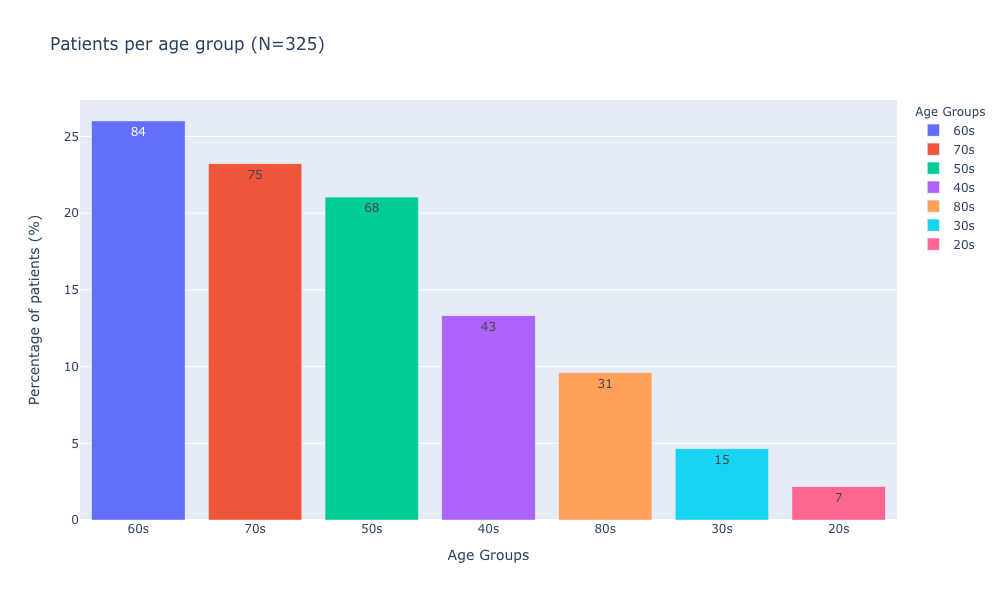

In [380]:
fig5 = px.bar(agg_age_df, x="Age Bins", y="Percentage",title='Patients per age group (N=325)',
              color='Age Bins', text='Number of Patients',
              labels={'Age Bins':'Age Groups','Percentage':'Percentage of patients (%)'}, height=700, width=1000)

fig5.show(renderer='png', width=1000, height=600)

### Cleaning the data

In [194]:
# Removing the row with negative cath_time because it is not possible. The row also had too many missing values

df_final = df_final.drop(df_final[df_final['cath_time'] <0].index, axis=0)

In [195]:
df_final.replace({'<undefined>':np.nan, 'Not done':np.nan},inplace=True)

#### Removing rows with a lot of missing data leads to a total of 322 subject information

In [196]:
# getting the index of all the rows with more than 20 missing values
missing_rows = list(df_final[df_final.isnull().sum(axis=1) >= 20].index)

# Removing the rows with more than 20 missing values
df_final.drop(missing_rows, inplace=True)

### Any relationship between Age, proc_time, cath_time and fluoro_time

In [197]:
age_times_df = df_final[['age_bins','proc_time','cath_time','fluoro_time']]

In [198]:
# Removing the row with negative cath_time because it is not possible. The row also had too many missing values

age_times_df = age_times_df.drop(age_times_df[age_times_df['cath_time'] <0].index, axis=0)

In [199]:
age_times_df.replace({'<undefined>':np.nan, 'Not done':np.nan},inplace=True)

In [200]:
# Deleting all rows containing no data
age_times_df = age_times_df.dropna(how='all',axis=0)

In [201]:
# removing rows with all three times missing
times_missing = list(age_times_df[age_times_df.isnull().sum(axis=1) >= 3].index)
age_times_df.drop(times_missing, inplace=True)

#Removing data without age information
age_times_df = age_times_df[~age_times_df['age_bins'].isna()]

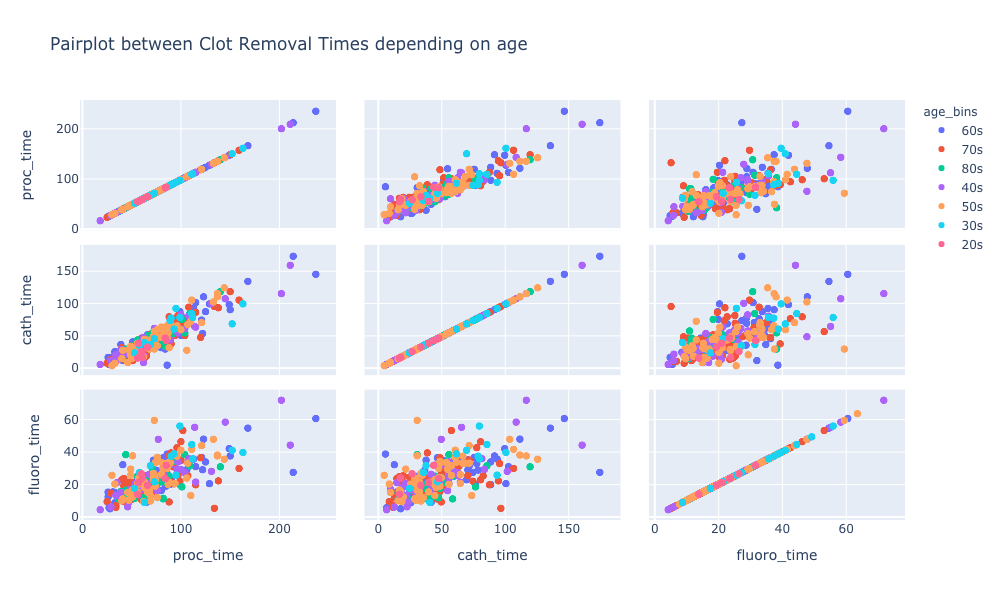

In [381]:
# Creating a pairplot between the  

fig6 = px.scatter_matrix(age_times_df,dimensions=['proc_time','cath_time','fluoro_time'],
                         color='age_bins', title='Pairplot between Clot Removal Times depending on age'
                        ,height=600, width=1000)
fig6.show(renderer='png', width=1000, height=600)

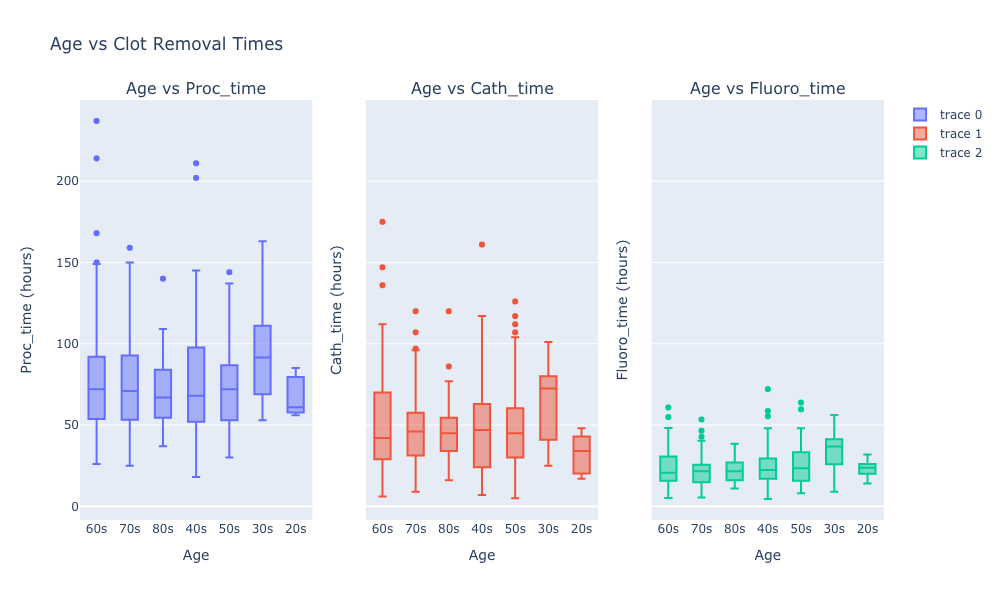

In [382]:
# Box plots of Age vs Clot Removal Times
subfig2 = make_subplots(rows=1, cols=3,subplot_titles=('Age vs Proc_time','Age vs Cath_time','Age vs Fluoro_time'),
                       shared_yaxes=True)
subfig2.add_box(row=1, col=1,y=age_times_df['proc_time'],x=age_times_df['age_bins'])
subfig2.add_box(row=1, col=2,y=age_times_df['cath_time'],x=age_times_df['age_bins'])
subfig2.add_box(row=1, col=3,y=age_times_df['fluoro_time'],x=age_times_df['age_bins'])

# Update xaxis properties
subfig2.update_xaxes(title_text="Age", row=1, col=1)
subfig2.update_xaxes(title_text="Age", row=1, col=2)
subfig2.update_xaxes(title_text="Age", row=1, col=3)


# Update yaxis properties
subfig2.update_yaxes(title_text="Proc_time (hours)", row=1, col=1)
subfig2.update_yaxes(title_text="Cath_time (hours)", row=1, col=2)
subfig2.update_yaxes(title_text="Fluoro_time (hours)", row=1, col=3)
subfig2.update_layout(height=600, width=1000, title_text="Age vs Clot Removal Times")
subfig2.show(renderer='png', width=1000, height=600)

### BMI vs proc_time, cath_time and fluoro_time

In [204]:
bmi_times_df = df_final[['bmi_bins','proc_time','cath_time','fluoro_time']]

In [205]:
# Removing the row with negative cath_time because it is not possible. The row also had too many missing values

bmi_times_df = bmi_times_df.drop(bmi_times_df[bmi_times_df['cath_time'] <0].index, axis=0)

In [206]:
# removing rows with all three times missing
times_missing = list(bmi_times_df[bmi_times_df.isnull().sum(axis=1) >= 3].index)
bmi_times_df.drop(times_missing, inplace=True)

#Removing data without age information
bmi_times_df = bmi_times_df[~bmi_times_df['bmi_bins'].isna()]

In [207]:
bmi_times_df.describe()

proc_time   cath_time  fluoro_time
count  294.000000  296.000000   311.000000
mean    76.761905   48.888514    24.094051
std     32.659968   27.968101    11.175011
min     18.000000    5.000000     4.500000
25%     55.000000   30.000000    15.900000
50%     72.000000   44.500000    21.730000
75%     91.000000   61.000000    30.300000
max    237.000000  175.000000    72.100000

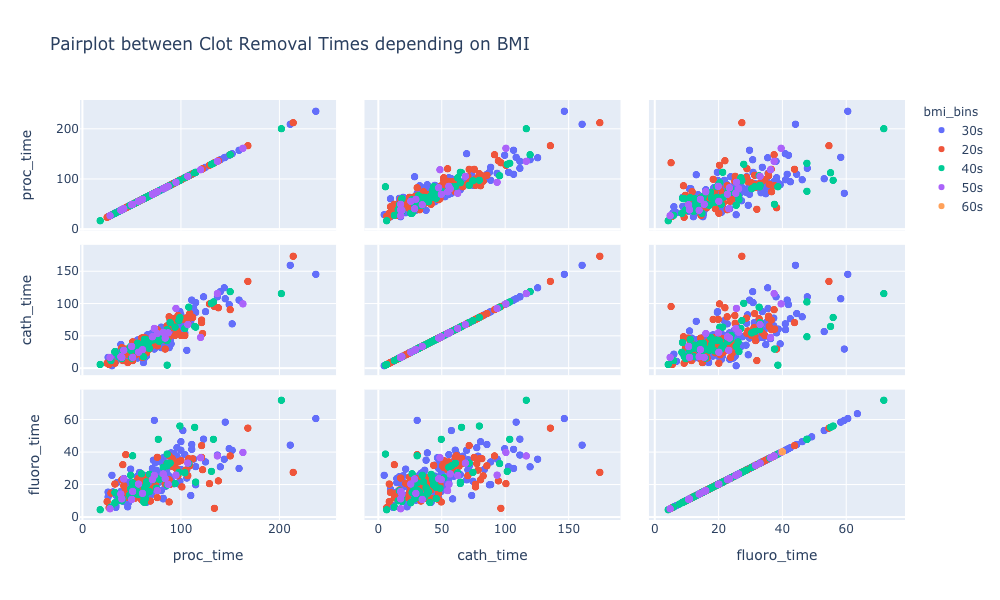

In [383]:
fig7 = px.scatter_matrix(bmi_times_df,dimensions=['proc_time','cath_time','fluoro_time'],color='bmi_bins', 
                         title='Pairplot between Clot Removal Times depending on BMI'
                        ,height=600, width=1000)
fig7.show(renderer='png', width=1000, height=600)

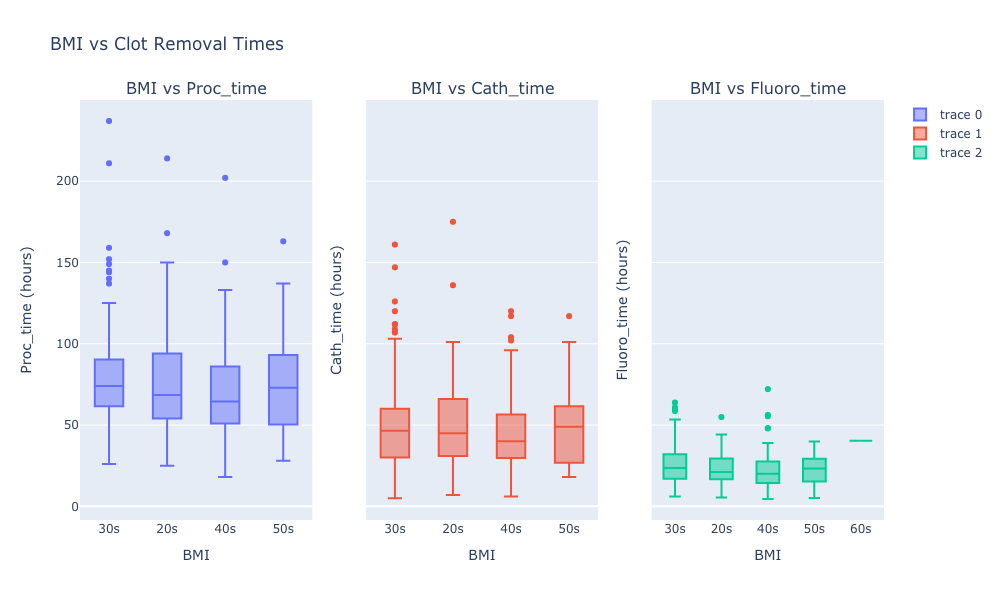

In [384]:
# Box plots of BMI vs Clot Removal Times
subfig3 = make_subplots(rows=1, cols=3,subplot_titles=('BMI vs Proc_time','BMI vs Cath_time','BMI vs Fluoro_time'),
                       shared_yaxes=True)
subfig3.add_box(row=1, col=1,y=bmi_times_df['proc_time'],x=bmi_times_df['bmi_bins'])
subfig3.add_box(row=1, col=2,y=bmi_times_df['cath_time'],x=bmi_times_df['bmi_bins'])
subfig3.add_box(row=1, col=3,y=bmi_times_df['fluoro_time'],x=bmi_times_df['bmi_bins'])

# Update xaxis properties
subfig3.update_xaxes(title_text="BMI", row=1, col=1)
subfig3.update_xaxes(title_text="BMI", row=1, col=2)
subfig3.update_xaxes(title_text="BMI", row=1, col=3)

# Update yaxis properties
subfig3.update_yaxes(title_text="Proc_time (hours)", row=1, col=1)
subfig3.update_yaxes(title_text="Cath_time (hours)", row=1, col=2)
subfig3.update_yaxes(title_text="Fluoro_time (hours)", row=1, col=3)

subfig3.update_layout(height=600, width=1000, title_text="BMI vs Clot Removal Times")
subfig3.show(renderer='png', width=1000, height=600)

### Does Hospital Duration depend on age?

In [210]:
age_hosp_df = df_final[['age_bins','hosp_duration']]

#Removing missing values and negative values
age_hosp_df = age_hosp_df.dropna(how='any',axis=0)
age_hosp_df = age_hosp_df[age_hosp_df['hosp_duration'] >0]
age_hosp_df.describe()

hosp_duration
count     284.000000
mean        5.378993
std         5.026072
min         1.225694
25%         2.860764
50%         4.000694
75%         5.748958
max        47.639583

In [211]:
agg_age_hosp_df = age_hosp_df.groupby('age_bins')['age_bins','hosp_duration'].agg('median').round(2)

<ipython-input-211-898d1ebc1804>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



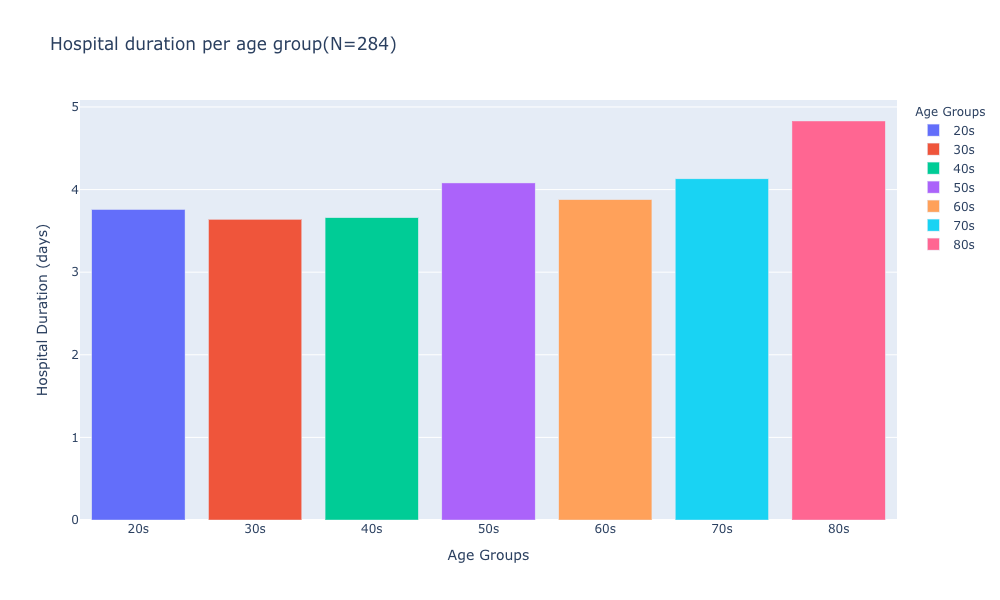

In [385]:
fig8 = px.bar(agg_age_hosp_df,color=agg_age_hosp_df.index,title='Hospital duration per age group(N=284)',
              labels={'age_bins':'Age Groups','value':'Hospital Duration (days)'}, height=600, width=1000)
fig8.show(renderer='png', width=1000, height=600)

### Does ICU duration depening on age?

In [213]:
age_icu_df = df_final[['age_bins','icu_duration']]

#Removing missing values and negative values
age_icu_df = age_icu_df.dropna(how='any',axis=0)
age_icu_df = age_icu_df[age_icu_df['icu_duration'] > 0]
age_icu_df.describe()

icu_duration
count    106.000000
mean       2.527044
std        2.715228
min        0.075000
25%        1.148611
50%        1.832986
75%        2.909722
max       22.085417

In [214]:
agg_age_icu_df = age_icu_df.groupby('age_bins')['age_bins','icu_duration'].agg('median')

<ipython-input-214-a98db23f518b>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



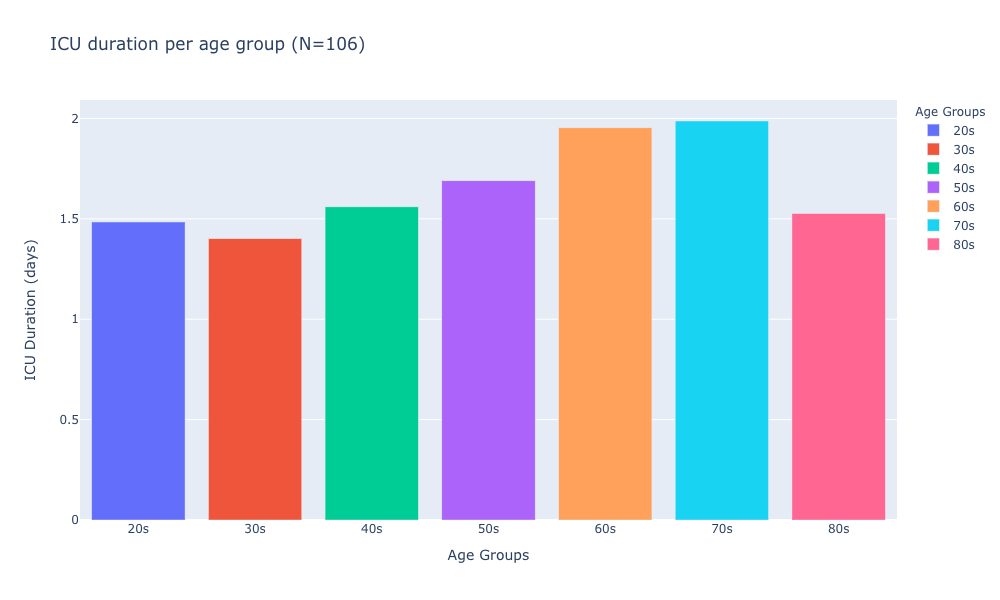

In [386]:
fig9 = px.bar(agg_age_icu_df,color=agg_age_icu_df.index,title='ICU duration per age group (N=106)',
              labels={'age_bins':'Age Groups','value':'ICU Duration (days)'}, height=600, width=1000)
fig9.show(renderer='png', width=1000, height=600)

### Summary of History of Pulmonary Embolism

In [216]:
pe_dvt_df = df_final[['SUBJECTID','hx_pe','hx_dvt','cur_dvt']]
pe_dvt_df.fillna('No',inplace=True)

In [217]:
pe_dvt_df['History of PE or DVT and Current DVT'] = pe_dvt_df['hx_pe']

In [218]:
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'Yes') & (pe_dvt_df['hx_dvt'] == 'No') & (pe_dvt_df['cur_dvt'] == 'No')] = 'History of PE'
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'Yes') & (pe_dvt_df['hx_dvt'] == 'No') & (pe_dvt_df['cur_dvt'] == 'Yes')] = 'History of PE and Current DVT'
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'Yes') & (pe_dvt_df['hx_dvt'] == 'Yes') & (pe_dvt_df['cur_dvt'] == 'No')] = 'History of PE and History of DVT'
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'No') & (pe_dvt_df['hx_dvt'] == 'No') & (pe_dvt_df['cur_dvt'] == 'No')] = 'No History of PE or History of DVT or Current DVT'
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'No') & (pe_dvt_df['hx_dvt'] == 'Yes') & (pe_dvt_df['cur_dvt'] == 'No')] = 'History of DVT'
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'No') & (pe_dvt_df['hx_dvt'] == 'No') & (pe_dvt_df['cur_dvt'] == 'Yes')] = 'Current DVT'
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'No') & (pe_dvt_df['hx_dvt'] == 'Yes') & (pe_dvt_df['cur_dvt'] == 'Yes')] = 'History of DVT and Current DVT'
pe_dvt_df['History of PE or DVT and Current DVT'].loc[(pe_dvt_df['hx_pe'] == 'Yes') & (pe_dvt_df['hx_dvt'] == 'Yes') & (pe_dvt_df['cur_dvt'] == 'Yes')] = 'History of PE and History of DVT and Current DVT'

In [219]:
pe_dvt_df = pe_dvt_df[pe_dvt_df['History of PE or DVT and Current DVT'] != '<undefined>']

In [220]:
pe_dvt_df.drop(['hx_pe','hx_dvt','cur_dvt'],axis=1,inplace=True)

In [221]:
agg_pe_dvt_df1 = pe_dvt_df['History of PE or DVT and Current DVT'].value_counts()#.rename_axis(['age_bins']).reset_index(name='counts')
agg_pe_dvt_df2 = ((pe_dvt_df['History of PE or DVT and Current DVT'].value_counts(normalize=True)*100).round(2))#.rename_axis(['age_bins']).reset_index(name='percentage')

In [222]:
agg_pe_dvt_df = pd.DataFrame({'Number of occurences': agg_pe_dvt_df1,'Percentage':agg_pe_dvt_df2})

In [223]:
agg_pe_dvt_df = agg_pe_dvt_df.reset_index()
agg_pe_dvt_df.columns = ['History of PE or DVT or Current DVT','Number of Patients','Percentage']

In [224]:
agg_pe_dvt_df

History of PE or DVT or Current DVT  Number of Patients  \
0                                        Current DVT                 158   
1  No History of PE or History of DVT or Current DVT                  89   
2                     History of DVT and Current DVT                  30   
3                                     History of DVT                  15   
4   History of PE and History of DVT and Current DVT                  14   
5                                      History of PE                   8   
6                   History of PE and History of DVT                   4   
7                      History of PE and Current DVT                   4   

   Percentage  
0       49.07  
1       27.64  
2        9.32  
3        4.66  
4        4.35  
5        2.48  
6        1.24  
7        1.24

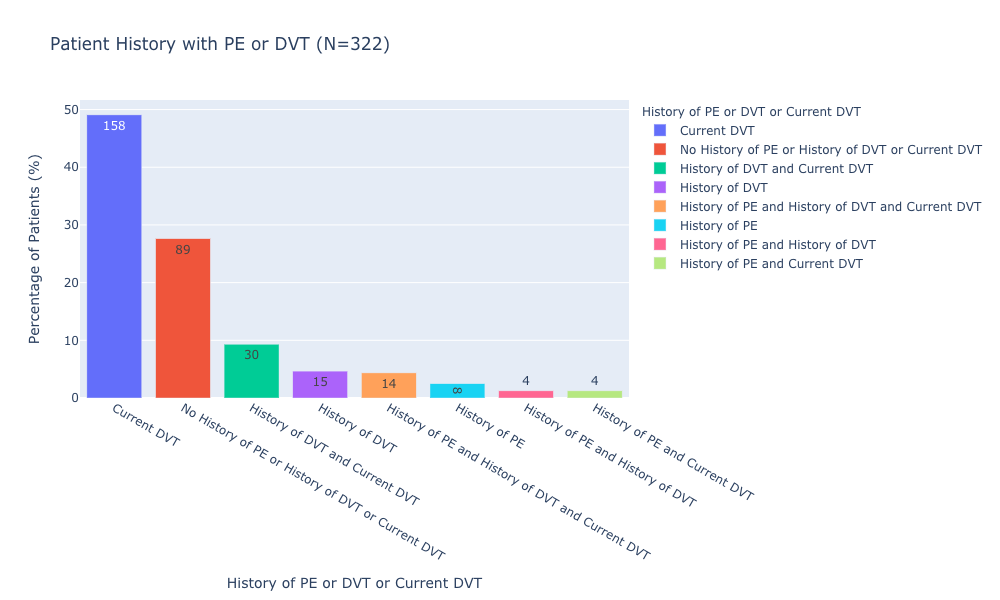

In [387]:
fig10 = px.bar(agg_pe_dvt_df, x='History of PE or DVT or Current DVT', y= 'Percentage', 
       color='History of PE or DVT or Current DVT', text='Number of Patients', height=600, width=1000,
       labels={'Percentage':'Percentage of Patients (%)'}, title = 'Patient History with PE or DVT (N=322)')

fig10.show(renderer='png', width=1000, height=600)

### Summary of clot removal score

In [226]:
#Creating a df to find frequency of clot removal score in patients
agg_crm_df1 = df_final['clot_removal_score'].value_counts()
agg_crm_df2 = (df_final['clot_removal_score'].value_counts(normalize=True)*100).round(2)

In [227]:
agg_crm_df = pd.DataFrame({'Counts':agg_crm_df1,'Percentage':agg_crm_df2})
agg_crm_df = agg_crm_df.reset_index()
agg_crm_df.columns = ['Clot_Removal_Score','Number of Patients','Percentage of Patients']
agg_crm_df

Clot_Removal_Score  Number of Patients  Percentage of Patients
0                 4.0                 138                   48.76
1                 3.0                  91                   32.16
2                 2.0                  37                   13.07
3                 1.0                  16                    5.65
4                 0.0                   1                    0.35

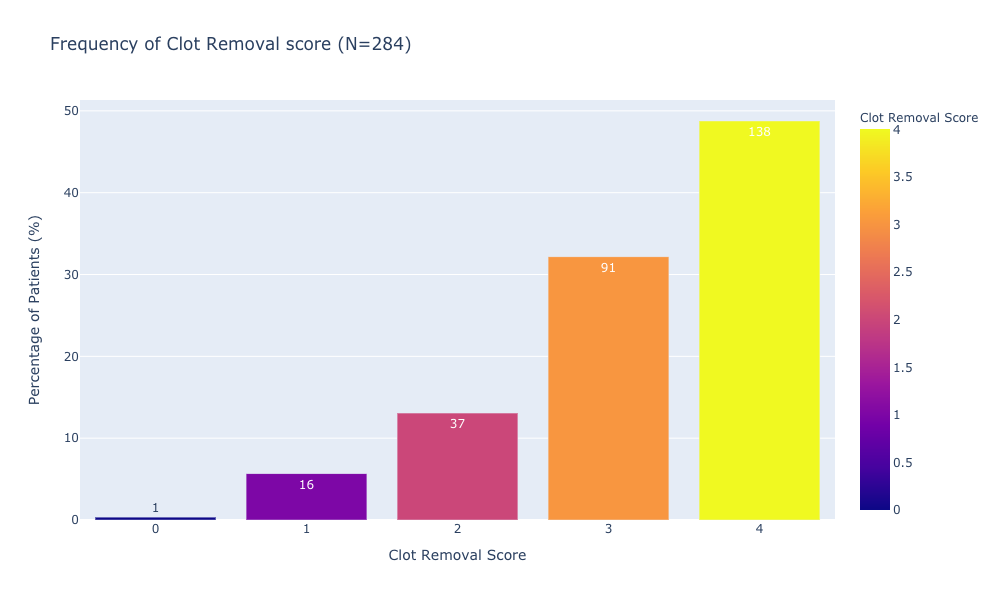

In [388]:
fig11 = px.bar(agg_crm_df, x="Clot_Removal_Score", y="Percentage of Patients",
               title='Frequency of Clot Removal score (N=284)',
               color='Clot_Removal_Score',text='Number of Patients', height=600, width=1000,
               labels={'Clot_Removal_Score':'Clot Removal Score','Percentage of Patients':'Percentage of Patients (%)'})

fig11.update_xaxes(categoryorder='category ascending')

# show the image
fig11.show(renderer='png', width=1000, height=600)

### Summary of estimated residual clot

In [229]:
#Creating Estimated Residual clot % bins

df_final['est_residual_clot_bins'] = pd.cut(df_final['est_residual_clot'], bins = [0,10,20,30,40,50,60,70,80,90,100], labels = ['0-10%','10-20%', '20-30%','30-40%','40-50%','50-60%','60-70%','70-80%','80-90%','90-100%'])

In [230]:
#Creating a df to find frequency of clot removal score in patients
agg_erc_df1 = df_final['est_residual_clot_bins'].value_counts()
agg_erc_df2 = (df_final['est_residual_clot_bins'].value_counts(normalize=True)*100).round(2)

In [231]:
agg_erc_df = pd.DataFrame({'Counts':agg_erc_df1,'Percentage':agg_erc_df2})
agg_erc_df = agg_erc_df.reset_index()
agg_erc_df.columns = ['Estimated Residual Clot','Number of Patients','Percentage of Patients']
agg_erc_df

Estimated Residual Clot  Number of Patients  Percentage of Patients
0                  10-20%                  64                   27.35
1                   0-10%                  58                   24.79
2                  20-30%                  48                   20.51
3                  40-50%                  23                    9.83
4                  30-40%                  15                    6.41
5                  70-80%                   9                    3.85
6                  50-60%                   7                    2.99
7                  60-70%                   6                    2.56
8                  80-90%                   2                    0.85
9                 90-100%                   2                    0.85

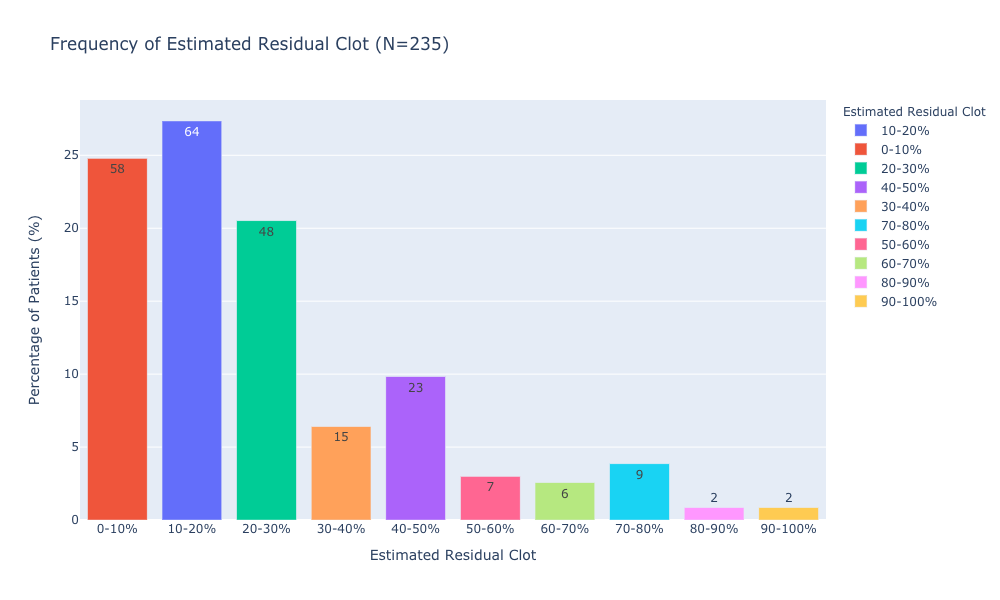

In [389]:
#Creating a df to find frequency of estimated residual clot in patients
fig12 = px.bar(agg_erc_df, x="Estimated Residual Clot", y="Percentage of Patients",
               title='Frequency of Estimated Residual Clot (N=235)',
               color='Estimated Residual Clot',height=600, width=1000, text='Number of Patients',
               labels={'Percentage of Patients':'Percentage of Patients (%)'})

fig12.update_xaxes(categoryorder='category ascending')

# show the image
fig12.show(renderer='png', width=1000, height=600)

### Summary of estimated blood loss

In [233]:
df_final['ebl_bins'] = pd.cut(df_final['ebl'], bins = [0,100,200,300,400,500,600,700,800,900,1000,7500], labels = ['0-100ml','100-200ml', '200-300ml','300-400ml','400-500ml','500-600ml','600-700ml','700-800ml','800-900ml','900-1000ml','>1000ml'])

In [234]:
#Creating a df to find frequency of estimated blood loss in patients
agg_ebl_df1 = df_final['ebl_bins'].value_counts()
agg_ebl_df2 = (df_final['ebl_bins'].value_counts(normalize=True)*100).round(2)

In [235]:
agg_ebl_df = pd.DataFrame({'Counts':agg_ebl_df1,'Percentage':agg_ebl_df2})
agg_ebl_df = agg_ebl_df.reset_index()
agg_ebl_df.columns = ['Estimated Blood Loss','Number of Patients','Percentage of Patients']
agg_ebl_df

Estimated Blood Loss  Number of Patients  Percentage of Patients
0               0-100ml                  63                   23.95
1             200-300ml                  48                   18.25
2             100-200ml                  41                   15.59
3             300-400ml                  41                   15.59
4             400-500ml                  39                   14.83
5             500-600ml                  13                    4.94
6             700-800ml                   6                    2.28
7             600-700ml                   5                    1.90
8               >1000ml                   3                    1.14
9             800-900ml                   2                    0.76
10           900-1000ml                   2                    0.76

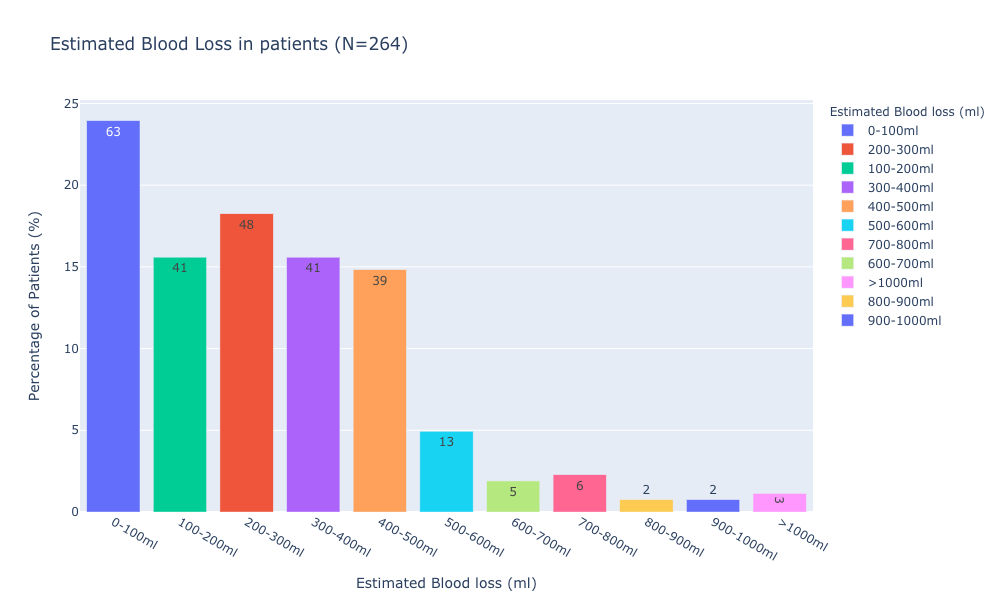

In [390]:
fig13 = px.bar(agg_ebl_df, x="Estimated Blood Loss", y="Percentage of Patients",
               title='Estimated Blood Loss in patients (N=264)', text='Number of Patients',
               color='Estimated Blood Loss', height=600, width=1000,
               labels={'Estimated Blood Loss':'Estimated Blood loss (ml)','Percentage of Patients':'Percentage of Patients (%)'})

fig13.update_xaxes(categoryorder='category ascending')

# show the image
fig13.show(renderer='png', width=1000, height=600)

### Summary of CUPE

In [237]:
agg_cupe_df = df_final[df_final['CUPE'] != '<undefined>']

In [238]:
#Creating a df to find frequency CUPE in patients
agg_cupe_df1 = agg_cupe_df['CUPE'].value_counts()
agg_cupe_df2 = (agg_cupe_df['CUPE'].value_counts(normalize=True)*100).round(2)

In [239]:
agg_cupe_df = pd.DataFrame({'Counts':agg_cupe_df1,'Percentage':agg_cupe_df2})
agg_cupe_df = agg_cupe_df.reset_index()
agg_cupe_df.columns = ['CUPE','Number of Patients','Percentage of Patients']
agg_cupe_df

CUPE  Number of Patients  Percentage of Patients
0  Submassive (Intermediate Risk)                 304                   94.41
1             Massive (High Risk)                  18                    5.59

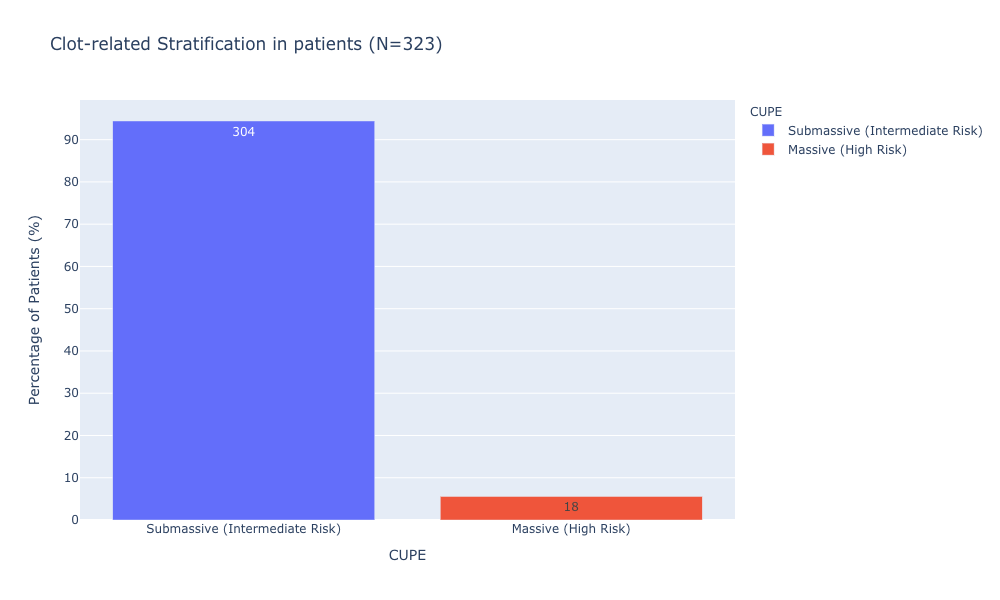

In [391]:
fig14 = px.bar(agg_cupe_df, x="CUPE", y="Percentage of Patients",
               title='Clot-related Stratification in patients (N=323)', text='Number of Patients',
               color='CUPE', height=600, width=1000,
               labels={'Estimated Blood Loss':'Estimated Blood loss (ml)','Percentage of Patients':'Percentage of Patients (%)'})


# show the image
fig14.show(renderer='png', width=1000, height=600)

### Summary of Biomarkers

In [241]:
agg_bio_df = df_final[df_final['biomarkers'] != '<undefined>']

In [242]:
#Creating a df to find frequency CUPE in patients
agg_bio_df1 = agg_bio_df['biomarkers'].value_counts()
agg_bio_df2 = (agg_bio_df['biomarkers'].value_counts(normalize=True)*100).round(2)

In [243]:
agg_bio_df = pd.DataFrame({'Counts':agg_bio_df1,'Percentage':agg_bio_df2})
agg_bio_df = agg_bio_df.reset_index()
agg_bio_df.columns = ['Biomarkers','Number of Patients','Percentage of Patients']
agg_bio_df

Biomarkers  Number of Patients  Percentage of Patients
0        Yes                 292                   96.05
1         No                  12                    3.95

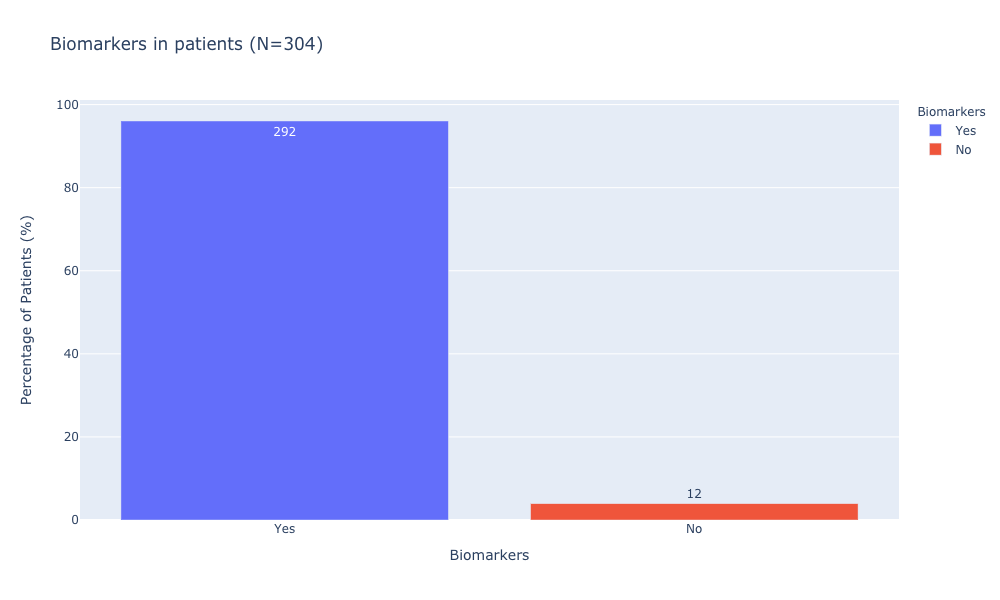

In [392]:
fig15 = px.bar(agg_bio_df, x="Biomarkers", y="Percentage of Patients",
               title='Biomarkers in patients (N=304)', text='Number of Patients',
               color='Biomarkers', height=600, width=1000,
               labels={'Percentage of Patients':'Percentage of Patients (%)'})


# show the image
fig15.show(renderer='png', width=1000, height=600)

### Summary of spesi

In [245]:
#Creating a df to find frequency of spesi in patients
agg_spesi_df1 = df_final['spesi'].value_counts()
agg_spesi_df2 = (df_final['spesi'].value_counts(normalize=True)*100).round(2)

In [246]:
agg_spesi_df = pd.DataFrame({'Counts':agg_spesi_df1,'Percentage':agg_spesi_df2})
agg_spesi_df = agg_spesi_df.reset_index()
agg_spesi_df.columns = ['SPESI','Number of Patients','Percentage of Patients']
agg_spesi_df

SPESI  Number of Patients  Percentage of Patients
0    2.0                 104                   34.90
1    1.0                 103                   34.56
2    0.0                  42                   14.09
3    3.0                  38                   12.75
4    4.0                   8                    2.68
5    5.0                   3                    1.01

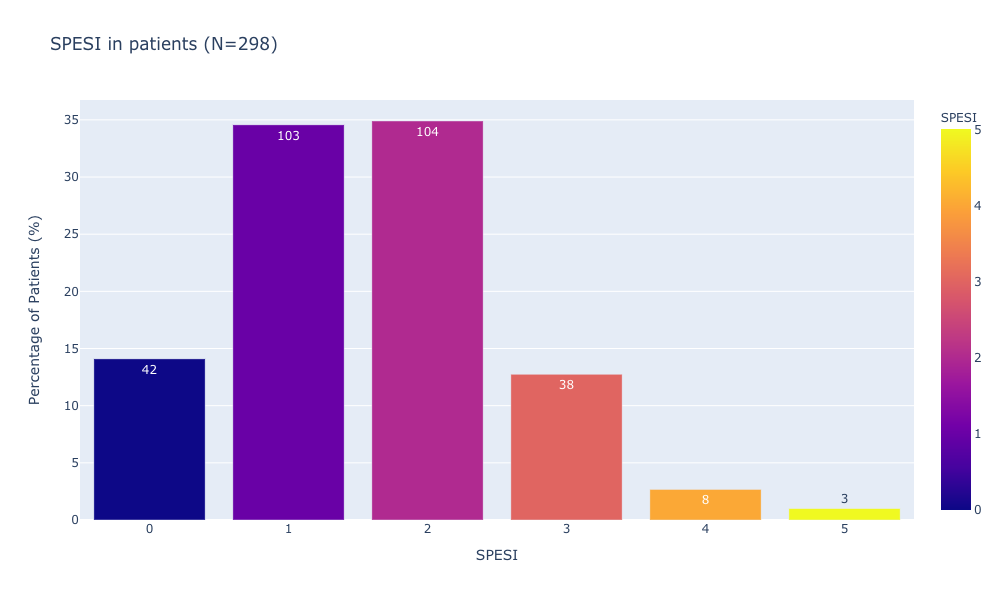

In [393]:
fig16 = px.bar(agg_spesi_df, x="SPESI", y="Percentage of Patients",
               title='SPESI in patients (N=298)', text='Number of Patients',
               color='SPESI', height=600, width=1000,
               labels={'Percentage of Patients':'Percentage of Patients (%)'})


# show the image
fig16.show(renderer='png', width=1000, height=600)

### Summary of Lytics contraindication

In [248]:
agg_lytic_df = df_final[df_final['lytics_contra'] != '<undefined>']

In [249]:
#Creating a df to find lytics contraindication in patients
agg_lytic_df1 = agg_lytic_df['lytics_contra'].value_counts()
agg_lytic_df2 = (agg_lytic_df['lytics_contra'].value_counts(normalize=True)*100).round(2)

In [250]:
agg_lytic_df = pd.DataFrame({'Counts':agg_lytic_df1,'Percentage':agg_lytic_df2})
agg_lytic_df = agg_lytic_df.reset_index()
agg_lytic_df.columns = ['Lytics Contraindication','Number of Patients','Percentage of Patients']
agg_lytic_df

Lytics Contraindication  Number of Patients  Percentage of Patients
0                      No                 199                   61.99
1                Relative                 107                   33.33
2                Absolute                  15                    4.67

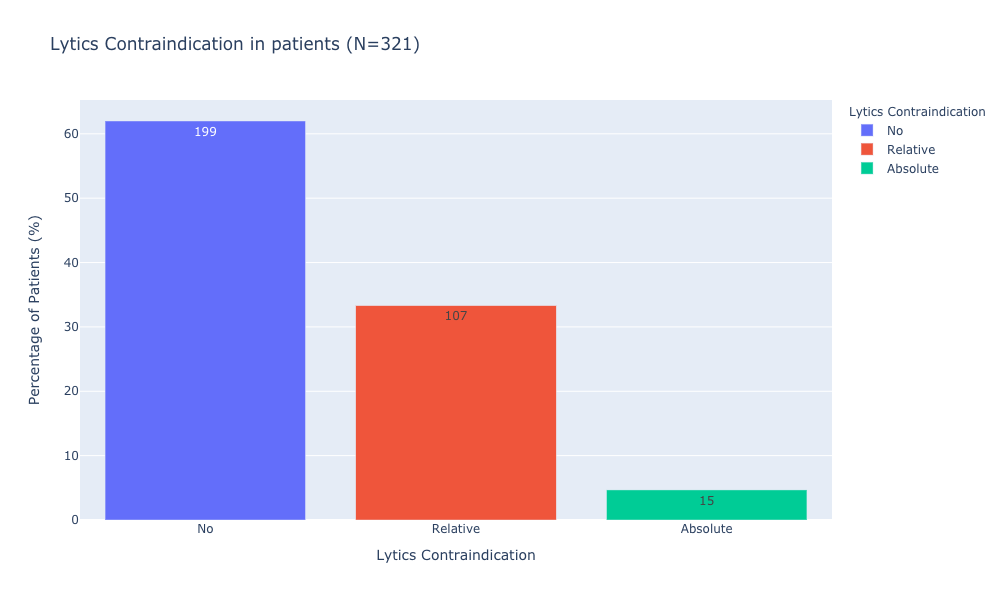

In [394]:
fig17 = px.bar(agg_lytic_df, x="Lytics Contraindication", y="Percentage of Patients",
               title='Lytics Contraindication in patients (N=321)', text='Number of Patients',
               color='Lytics Contraindication', height=600, width=1000,
               labels={'Percentage of Patients':'Percentage of Patients (%)'})


# show the image
fig17.show(renderer='png', width=1000, height=600)

### Change in dyspnea score before and after the procedure 

In [252]:
dyspnea_df = df_final[['dyspnea','dyspnea_30']]
dyspnea_df.replace({'<undefined>':np.nan, 'Not done':np.nan}, inplace=True)
dyspnea_df.dropna(how='any',axis=0, inplace=True)
dyspnea_df['dyspnea'] = dyspnea_df['dyspnea'].astype('int')

In [253]:
#Creating two dfs summarizing dyspnea and dyspnea_30 scores in all patients
agg_dysp_df = ((dyspnea_df['dyspnea'].value_counts(normalize=True)*100).round(2)).rename_axis(['dyspnea']).reset_index(name='dyspnea_counts')
agg_dysp_30_df = ((dyspnea_df['dyspnea_30'].value_counts(normalize=True)*100).round(2)).rename_axis(['dyspnea_30']).reset_index(name='dyspnea_30_counts')

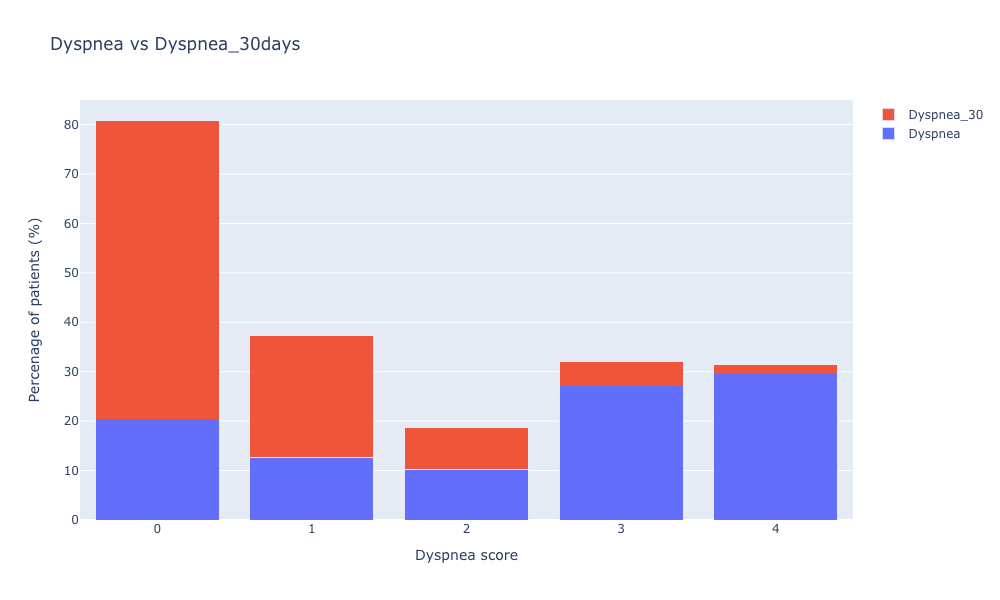

In [395]:
fig18 = go.Figure(data=[go.Bar(
    name = 'Dyspnea',
    x = agg_dysp_df['dyspnea'],
    y = agg_dysp_df['dyspnea_counts']
   ),
                       go.Bar(
    name = 'Dyspnea_30',
    x = agg_dysp_30_df['dyspnea_30'],
    y = agg_dysp_30_df['dyspnea_30_counts'],
                           
   )
])

fig18.update_layout(barmode='stack', title="Dyspnea vs Dyspnea_30days", height=600, width=1000, 
                    xaxis_title="Dyspnea score", yaxis_title="Percenage of patients (%)")
                  
fig18.show(renderer='png', width=1000, height=600)

### RV/LV ratio at baseline vs 48 hours

In [255]:
rvlv_48h_df = df_final[['rvlv_rat','rvlv_ratio_48h']].dropna(how='any')

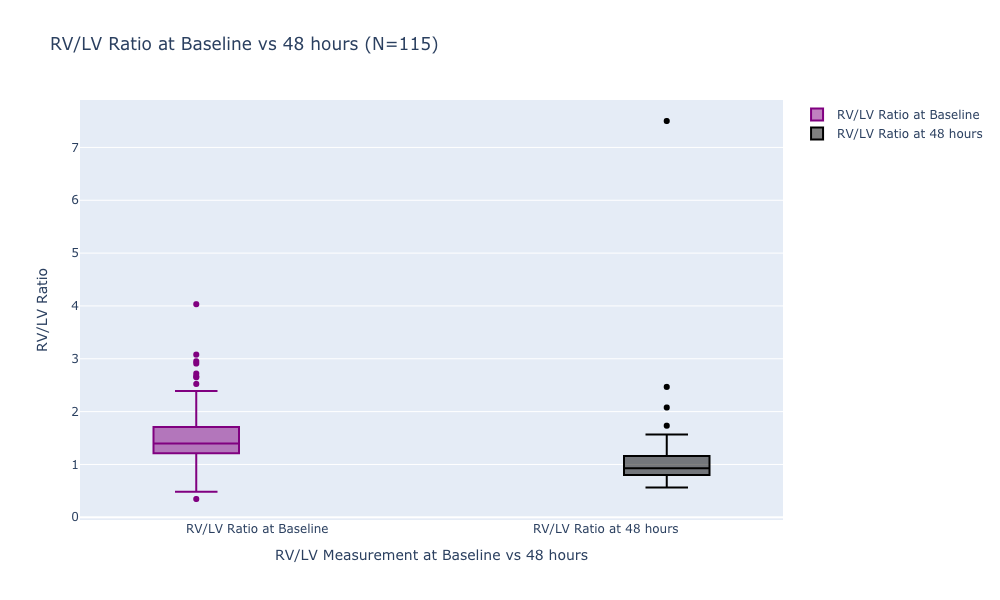

In [396]:
# Box plots
fig19 = go.Figure()
  
fig19.add_trace(go.Box(
  

    y=rvlv_48h_df['rvlv_rat'],
    name='RV/LV Ratio at Baseline',
    marker_color='purple'
))
  
fig19.add_trace(go.Box(
    y=rvlv_48h_df['rvlv_ratio_48h'],
    name='RV/LV Ratio at 48 hours',
    marker_color='black'
))
  
fig19.update_layout(boxmode='group',title="RV/LV Ratio at Baseline vs 48 hours (N=115)", height=600, width=1000, 
                    xaxis_title="RV/LV Measurement at Baseline vs 48 hours", yaxis_title="RV/LV Ratio")
fig19.show(renderer='png', width=1000, height=600)

In [257]:
#checking if the rvlv parameters violate normalization assumptions

print(stats.shapiro(rvlv_48h_df['rvlv_rat']))
print(stats.shapiro(rvlv_48h_df['rvlv_ratio_48h']))

ShapiroResult(statistic=0.868705689907074, pvalue=1.1399892585473026e-08)
ShapiroResult(statistic=0.39629417657852173, pvalue=1.1332742745843007e-19)


In [258]:
#Paired single sided t-test hypothesis testing 
#Null Hypothesis: The difference between the mean of rvlv_ratio_48h and rvlv_ratio at baseline is greater than or equal to 0

#The test is statistically significant and hence the null hypothesis is rejected and alternative hypothesis is true 
print(stats.ttest_rel(rvlv_48h_df['rvlv_rat'], rvlv_48h_df['rvlv_ratio_48h'],alternative='greater'))

Ttest_relResult(statistic=6.298579823538675, pvalue=2.904337914358868e-09)


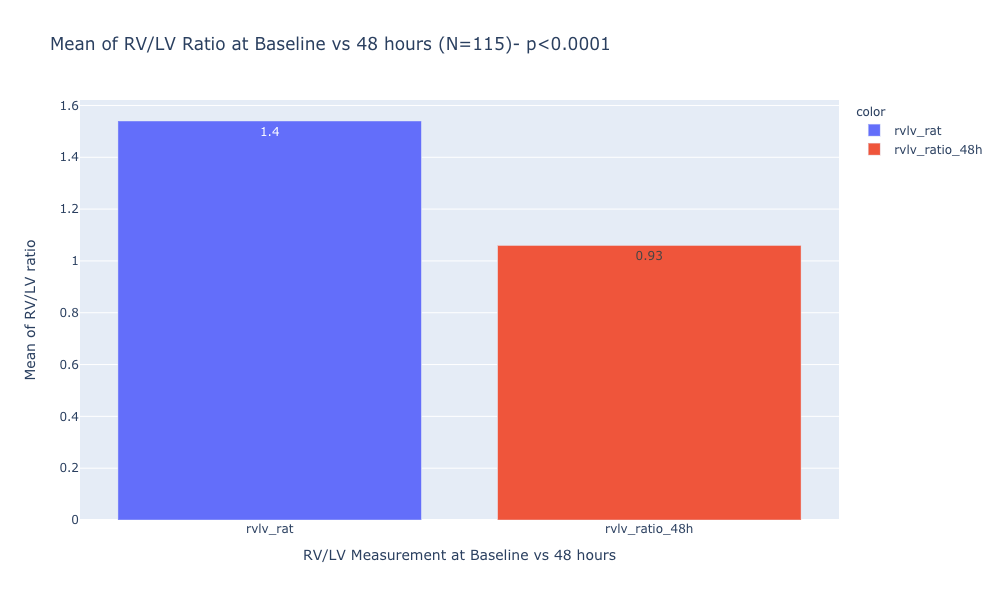

In [397]:
# Comparison of means
fig20 = px.bar(rvlv_48h_df.mean().round(2), title='Mean of RV/LV Ratio at Baseline vs 48 hours (N=115)- p<0.0001',
               color=rvlv_48h_df.columns, text= rvlv_48h_df.median().round(2), height=600, width=1000,
               labels={'index':'RV/LV Measurement at Baseline vs 48 hours','value':'Mean of RV/LV ratio'})
fig20.show(renderer='png', width=1000, height=600)

### RV/LV ratio at baseline vs 48 hours vs 30 days

In [260]:
rvlv_48h_30d_df = df_final[['rvlv_rat','rvlv_ratio_48h', 'rvlv_ratio_30d']].dropna(how='any')

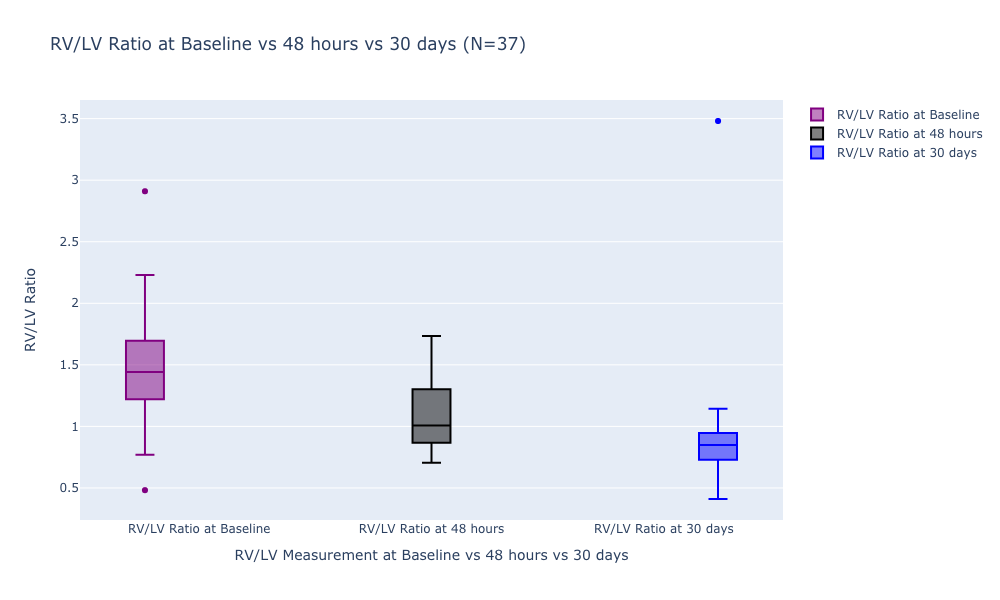

In [398]:
#Box plots
fig21 = go.Figure()
  
fig21.add_trace(go.Box(
  

    y=rvlv_48h_30d_df['rvlv_rat'],
    name='RV/LV Ratio at Baseline',
    marker_color='purple'
))
  
fig21.add_trace(go.Box(
    y=rvlv_48h_30d_df['rvlv_ratio_48h'],
    name='RV/LV Ratio at 48 hours',
    marker_color='black'
))

fig21.add_trace(go.Box(
    y=rvlv_48h_30d_df['rvlv_ratio_30d'],
    name='RV/LV Ratio at 30 days',
    marker_color='blue'
))
  
fig21.update_layout(boxmode='group',title="RV/LV Ratio at Baseline vs 48 hours vs 30 days (N=37)", height=600, 
                    width=1000, xaxis_title="RV/LV Measurement at Baseline vs 48 hours vs 30 days", 
                    yaxis_title="RV/LV Ratio")
fig21.show(renderer='png', width=1000, height=600)

In [262]:
#checking if the rvlv parameters violate normalization assumptions

print(stats.shapiro(rvlv_48h_30d_df['rvlv_rat']))
print(stats.shapiro(rvlv_48h_30d_df['rvlv_ratio_48h']))
print(stats.shapiro(rvlv_48h_30d_df['rvlv_ratio_30d']))

ShapiroResult(statistic=0.936761736869812, pvalue=0.03642859309911728)
ShapiroResult(statistic=0.9226672053337097, pvalue=0.013374537229537964)
ShapiroResult(statistic=0.4551735520362854, pvalue=1.4465402486951717e-10)


In [263]:
#ANOVA testing 
#Null Hypothesis: The difference between the mean of rvlv_ratio at baseline, rvlv_ratio_48h and rvlv_ratio_30d are equal to 0

#The test is statistically significant and hence the null hypothesis is rejected and alternative hypothesis is true stats.f_oneway(rvlv_48h_30d_df['rvlv_rat'],
stats.f_oneway(rvlv_48h_30d_df['rvlv_rat'],
               rvlv_48h_30d_df['rvlv_ratio_48h'],
               rvlv_48h_30d_df['rvlv_ratio_30d'])

F_onewayResult(statistic=21.217464844892405, pvalue=1.6906498774798364e-08)

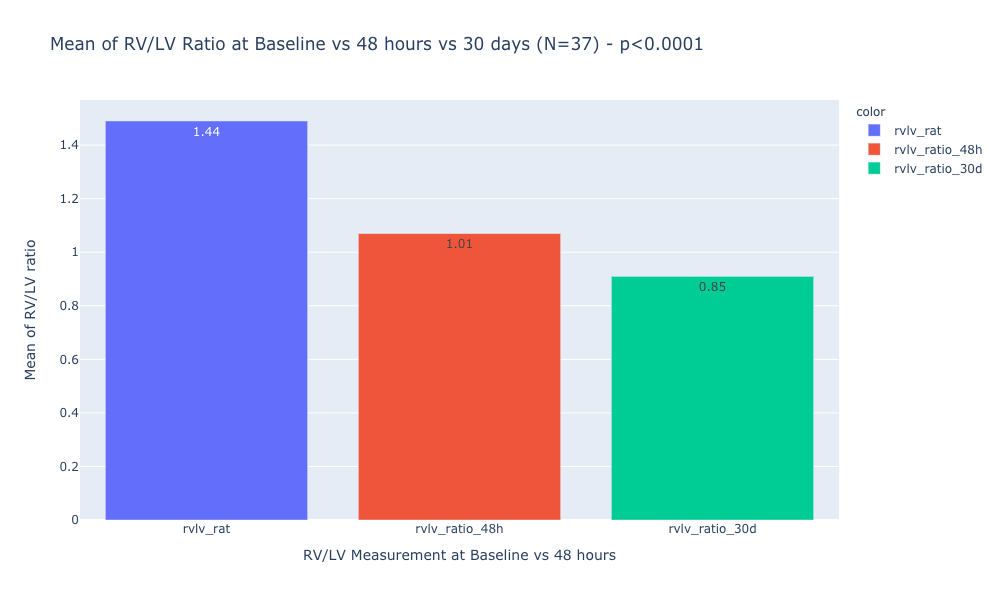

In [399]:
fig22 = px.bar(rvlv_48h_30d_df.mean().round(2), title='Mean of RV/LV Ratio at Baseline vs 48 hours vs 30 days (N=37) - p<0.0001',
               color=rvlv_48h_30d_df.columns, text=rvlv_48h_30d_df.median().round(2), height=600, width=1000,
               labels={'index':'RV/LV Measurement at Baseline vs 48 hours','value':'Mean of RV/LV ratio'})
fig22.show(renderer='png', width=1000, height=600)

### RV/LV ratio at baseline vs 30 days

In [265]:
rvlv_30d_df = df_final[['rvlv_rat','rvlv_ratio_30d']].dropna(how='any')

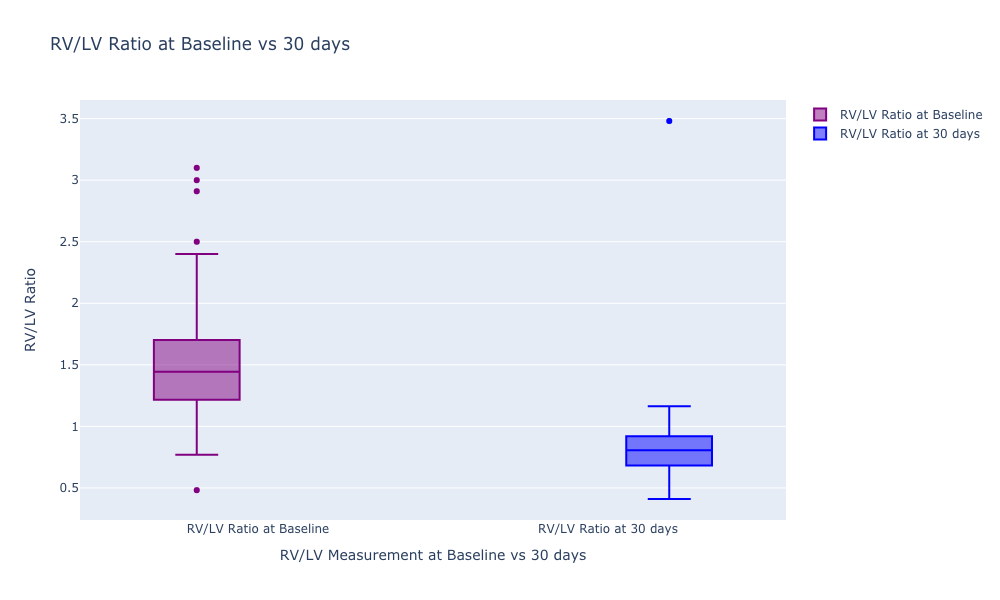

In [400]:
fig23 = go.Figure()
  
fig23.add_trace(go.Box(
  

    y=rvlv_30d_df['rvlv_rat'],
    name='RV/LV Ratio at Baseline',
    marker_color='purple'
))
  
fig23.add_trace(go.Box(
    y=rvlv_30d_df['rvlv_ratio_30d'],
    name='RV/LV Ratio at 30 days',
    marker_color='blue'
))
  
fig23.update_layout(boxmode='group',title="RV/LV Ratio at Baseline vs 30 days",  height=600, width=1000,
                    xaxis_title="RV/LV Measurement at Baseline vs 30 days", yaxis_title="RV/LV Ratio")
fig23.show(renderer='png', width=1000, height=600)

In [267]:
#checking if the rvlv parameters violate normalization assumptions

print(stats.shapiro(rvlv_30d_df['rvlv_rat']))
print(stats.shapiro(rvlv_30d_df['rvlv_ratio_30d']))

ShapiroResult(statistic=0.9010905623435974, pvalue=2.13111998164095e-05)
ShapiroResult(statistic=0.4983053207397461, pvalue=1.0827161378828415e-14)


In [268]:
#Paired single sided t-test hypothesis testing 
#Null Hypothesis: The difference between the mean of rvlv_ratio_30d and rvlv_ratio at baseline is greater than or equal to 0

#The test is statistically significant and hence the null hypothesis is rejected and alternative hypothesis is true 
print(stats.ttest_rel(rvlv_30d_df['rvlv_rat'], rvlv_30d_df['rvlv_ratio_30d'],alternative='greater'))

Ttest_relResult(statistic=12.039310292554598, pvalue=1.6890183262687764e-19)


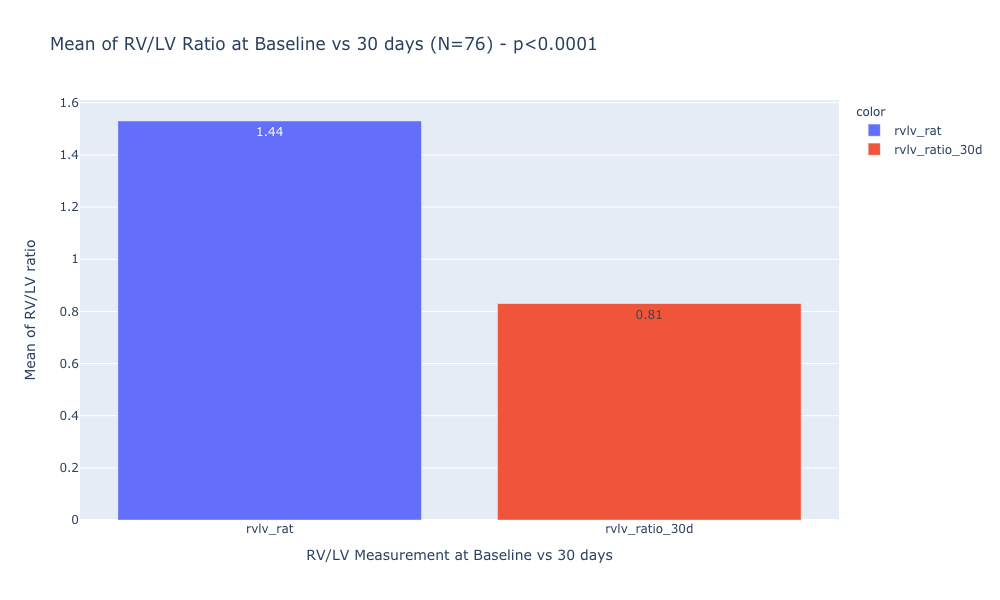

In [401]:
fig24 = px.bar(rvlv_30d_df.mean().round(2), title='Mean of RV/LV Ratio at Baseline vs 30 days (N=76) - p<0.0001',
               color=rvlv_30d_df.columns, text = rvlv_30d_df.median().round(2), height=600, width=1000,
               labels={'index':'RV/LV Measurement at Baseline vs 30 days','value':'Mean of RV/LV ratio'})
fig24.show(renderer='png', width=1000, height=600)

### Getting parameters from hemodynamics csv to compare with HR, SBP and DBP

In [270]:
hemo_df = pd.read_csv(r'hemodynamics.csv',usecols=['SUBJECTID','HR_pre','HR_post'])
outcomes_hr = df_final[['SUBJECTID','hr_30']]

In [271]:
hr_df = pd.merge(hemo_df,outcomes_hr, how='inner', on='SUBJECTID')

In [272]:
hr_df.drop('SUBJECTID',axis=1,inplace=True)
hr_df.head()

HR_pre  HR_post  hr_30
0   116.0     84.0   79.0
1   107.0     88.0    NaN
2   145.0     79.0   88.0
3   106.0     79.0   97.0
4   105.0    105.0   91.0

In [273]:
hr_df1 = hr_df[['HR_pre','HR_post']].dropna(how='any',axis=0)

In [274]:
hr_df2 = hr_df.dropna(how='any',axis=0)

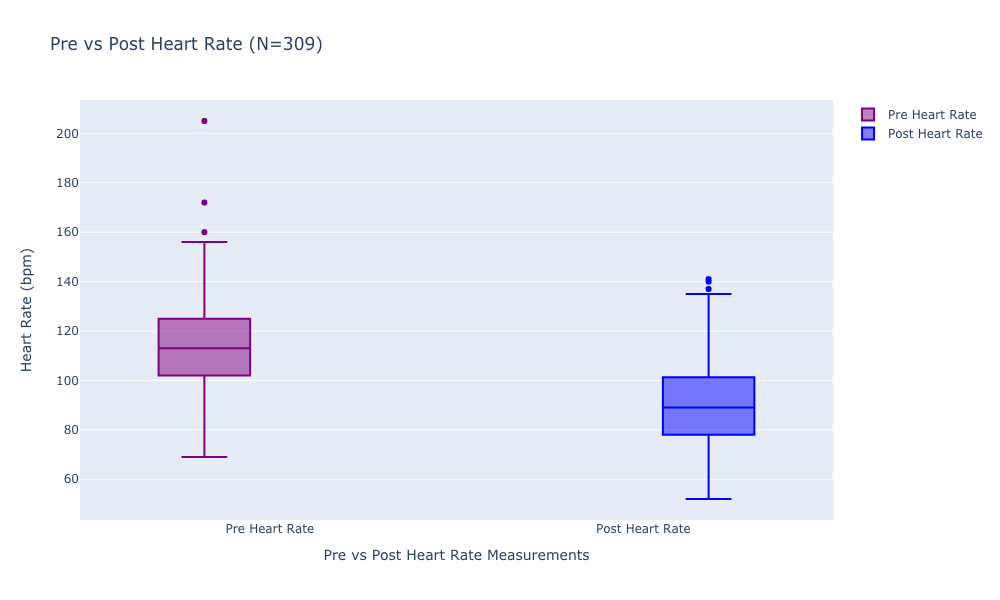

In [402]:
fig25 = go.Figure()
  
fig25.add_trace(go.Box(
  

    y=hr_df1['HR_pre'],
    name='Pre Heart Rate',
    marker_color='purple'
))
  
fig25.add_trace(go.Box(
    y=hr_df1['HR_post'],
    name='Post Heart Rate',
    marker_color='blue'
))
  
fig25.update_layout(boxmode='group',title="Pre vs Post Heart Rate (N=309)", height=600, width=1000,
                    xaxis_title="Pre vs Post Heart Rate Measurements", yaxis_title="Heart Rate (bpm)")
fig25.show(renderer='png', width=1000, height=600)

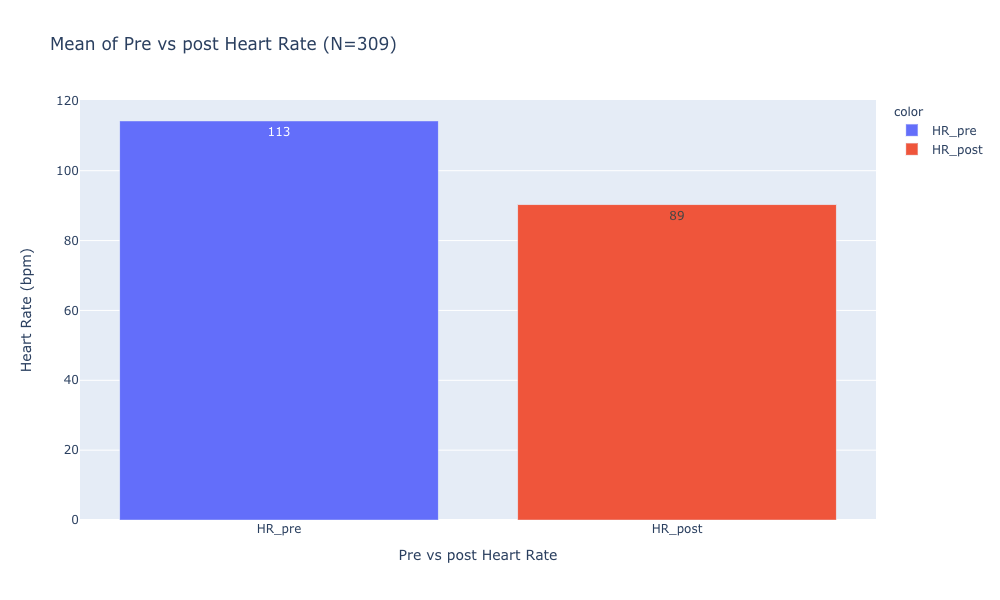

In [403]:
fig26 = px.bar(hr_df1.mean(), title='Mean of Pre vs post Heart Rate (N=309)',
               color=hr_df1.columns,labels={'index':'Pre vs post Heart Rate','value':'Heart Rate (bpm)'},
               text = hr_df1.median().round(2), height=600, width=1000)
fig26.show(renderer='png', width=1000, height=600)

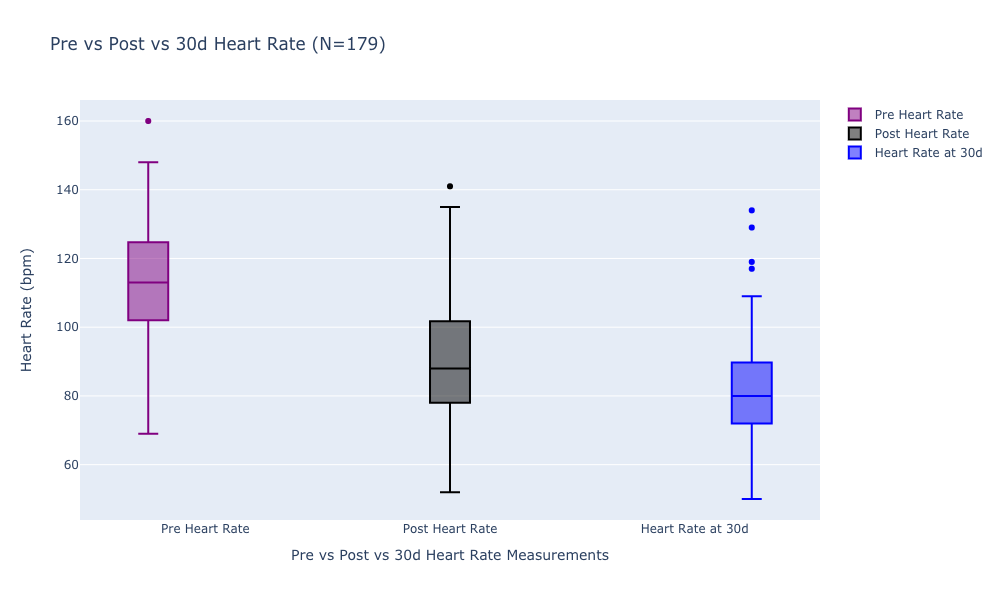

In [404]:
fig27 = go.Figure()
  
fig27.add_trace(go.Box(
  

    y=hr_df2['HR_pre'],
    name='Pre Heart Rate',
    marker_color='purple'
))
  

fig27.add_trace(go.Box(
    y=hr_df2['HR_post'],
    name='Post Heart Rate',
    marker_color='black'
))

fig27.add_trace(go.Box(
    y=hr_df2['hr_30'],
    name='Heart Rate at 30d',
    marker_color='blue'
))
  
fig27.update_layout(boxmode='group',title="Pre vs Post vs 30d Heart Rate (N=179)", height=600, width=1000,
                    xaxis_title="Pre vs Post vs 30d Heart Rate Measurements", yaxis_title="Heart Rate (bpm)")
fig27.show(renderer='png', width=1000, height=600)

In [278]:
#checking if the hr parameters violate normalization assumptions

print(stats.shapiro(hr_df2['HR_pre']))
print(stats.shapiro(hr_df2['HR_post']))
print(stats.shapiro(hr_df2['hr_30']))

#The p-value is greater than 0.5 and hence normalization assumptions are violated but considering the sample size is large enough, we can go ahead with the ANOVA test

ShapiroResult(statistic=0.9960229992866516, pvalue=0.9214192032814026)
ShapiroResult(statistic=0.987561047077179, pvalue=0.11619674414396286)
ShapiroResult(statistic=0.9796776175498962, pvalue=0.010243156924843788)


In [279]:
#ANOVA testing 
#Null Hypothesis: The difference between the mean of pre, post and 30th day heart rate is equal to 0

#The test is statistically significant and hence the null hypothesis is rejected and alternative hypothesis is true 
stats.f_oneway(hr_df2['HR_pre'],
               hr_df2['HR_post'],
               hr_df2['hr_30'])

F_onewayResult(statistic=190.2382519892814, pvalue=4.172961614272163e-63)

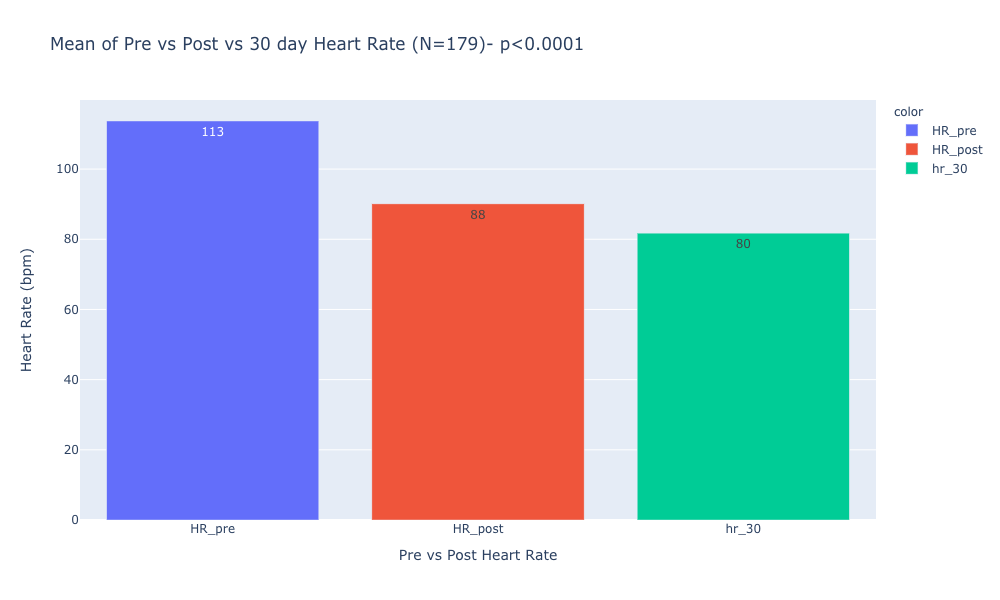

In [405]:
fig28 = px.bar(hr_df2.mean().round(2), title='Mean of Pre vs Post vs 30 day Heart Rate (N=179)- p<0.0001',
               color=hr_df2.columns,labels={'index':'Pre vs Post Heart Rate','value':'Heart Rate (bpm)'}, 
               text= hr_df2.median().round(2), height=600, width=1000)
fig28.show(renderer='png', width=1000, height=600)

### SBP before vs after

In [281]:
hemo_sbp_df = pd.read_csv(r'hemodynamics.csv',usecols=['SUBJECTID','SBP_pre'])
outcome_sbp_df = df_final[['SUBJECTID','SBP']]
sbp_df = pd.merge(hemo_sbp_df,outcome_sbp_df, how='inner', on='SUBJECTID').dropna(how='any')
sbp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 0 to 321
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SUBJECTID  181 non-null    object 
 1   SBP_pre    181 non-null    float64
 2   SBP        181 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.7+ KB


In [282]:
sbp_df.drop('SUBJECTID',axis=1,inplace=True)

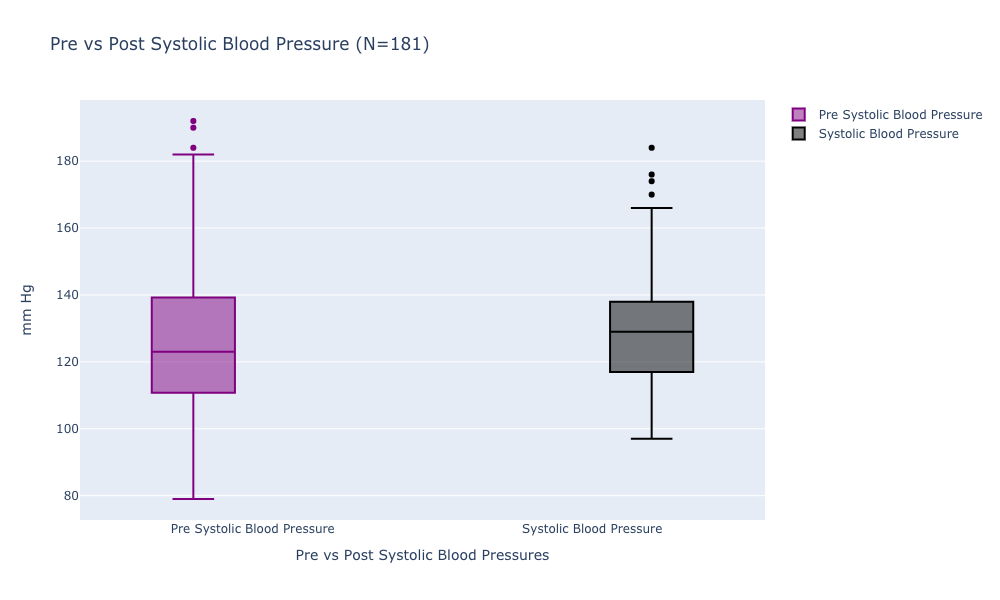

In [406]:
fig29 = go.Figure()
  
fig29.add_trace(go.Box(
  

    y=sbp_df['SBP_pre'],
    name='Pre Systolic Blood Pressure',
    marker_color='purple'
))
  

fig29.add_trace(go.Box(
    y=sbp_df['SBP'],
    name='Systolic Blood Pressure',
    marker_color='black'
))
  
fig29.update_layout(boxmode='group',title="Pre vs Post Systolic Blood Pressure (N=181)", height=600, width=1000,
                    xaxis_title="Pre vs Post Systolic Blood Pressures", yaxis_title="mm Hg")
fig29.show(renderer='png', width=1000, height=600)

In [284]:
#checking if the SBP parameters violate normalization assumptions

print(stats.shapiro(sbp_df['SBP_pre']))
print(stats.shapiro(sbp_df['SBP']))

ShapiroResult(statistic=0.9765236377716064, pvalue=0.0037821177393198013)
ShapiroResult(statistic=0.9674966335296631, pvalue=0.00031807145569473505)


In [285]:
#The test is not statistically significant. The after SBP is not lesser than the before SBP
print(stats.ttest_rel(sbp_df['SBP_pre'], sbp_df['SBP'],alternative='greater'))

Ttest_relResult(statistic=-1.7353870964153322, pvalue=0.9578081397083665)


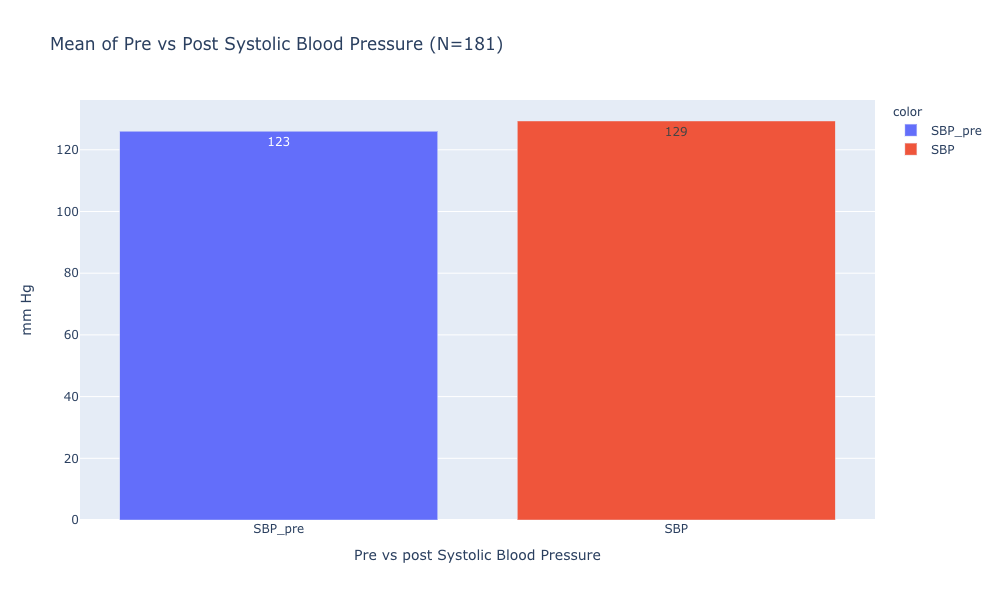

In [407]:
fig30 = px.bar(sbp_df.mean().round(2), title='Mean of Pre vs Post Systolic Blood Pressure (N=181)',height=600, width=1000,
               color=sbp_df.columns, text = sbp_df.median().round(2),
               labels={'index':'Pre vs post Systolic Blood Pressure','value':'mm Hg'})
fig30.show(renderer='png', width=1000, height=600)

### DBP before vs after

In [287]:
hemo_dbp_df = pd.read_csv(r'hemodynamics.csv',usecols=['SUBJECTID','DBP_pre'])
outcome_dbp_df = df_final[['SUBJECTID','DBP']]
dbp_df = pd.merge(hemo_dbp_df,outcome_dbp_df, how='inner', on='SUBJECTID').dropna(how='any')
dbp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 321
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SUBJECTID  180 non-null    object 
 1   DBP_pre    180 non-null    float64
 2   DBP        180 non-null    float64
dtypes: float64(2), object(1)
memory usage: 5.6+ KB


In [288]:
dbp_df.drop('SUBJECTID',axis=1,inplace=True)

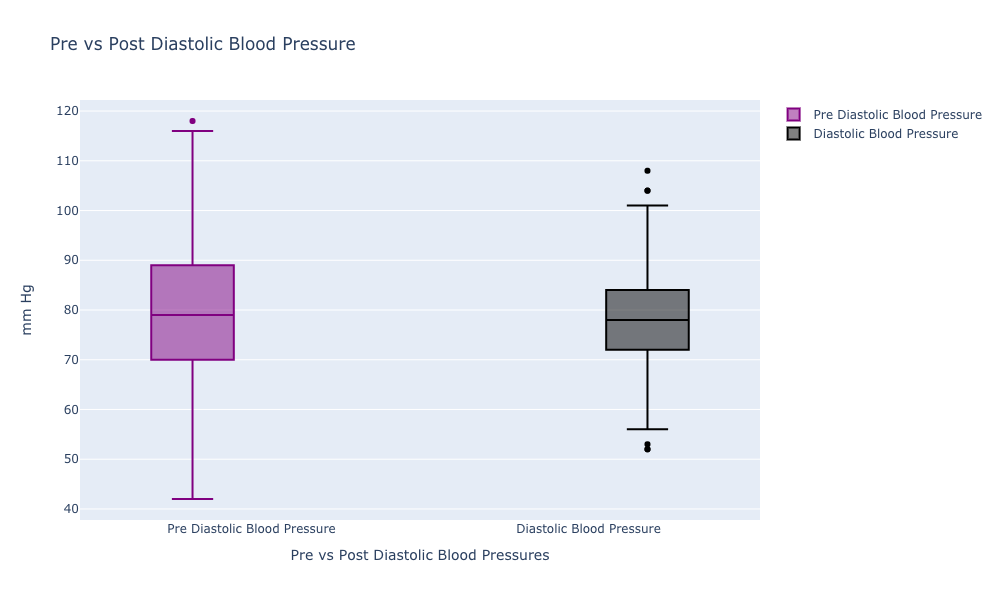

In [408]:
fig31 = go.Figure()
  
fig31.add_trace(go.Box(
  

    y=dbp_df['DBP_pre'],
    name='Pre Diastolic Blood Pressure',
    marker_color='purple'
))
  

fig31.add_trace(go.Box(
    y=dbp_df['DBP'],
    name='Diastolic Blood Pressure',
    marker_color='black'
))
  
fig31.update_layout(boxmode='group',title="Pre vs Post Diastolic Blood Pressure",height=600, width=1000,
                    xaxis_title="Pre vs Post Diastolic Blood Pressures", yaxis_title="mm Hg")
fig31.show(renderer='png', width=1000, height=600)

In [290]:
#checking if the DBP parameters violate normalization assumptions

print(stats.shapiro(dbp_df['DBP_pre']))
print(stats.shapiro(dbp_df['DBP']))

#The p-value is greater than 0.5 and hence normalization assumptions are violated but considering the sample size is large enough, we can go ahead with the paired t-test

ShapiroResult(statistic=0.9944002628326416, pvalue=0.7326743006706238)
ShapiroResult(statistic=0.9896876811981201, pvalue=0.21872571110725403)


In [291]:
#The test is not statistically significant. The after DBP is not lesser than the before DBP
print(stats.ttest_rel(dbp_df['DBP_pre'], dbp_df['DBP'],alternative='greater'))

Ttest_relResult(statistic=1.2712349259110531, pvalue=0.10264725461005642)


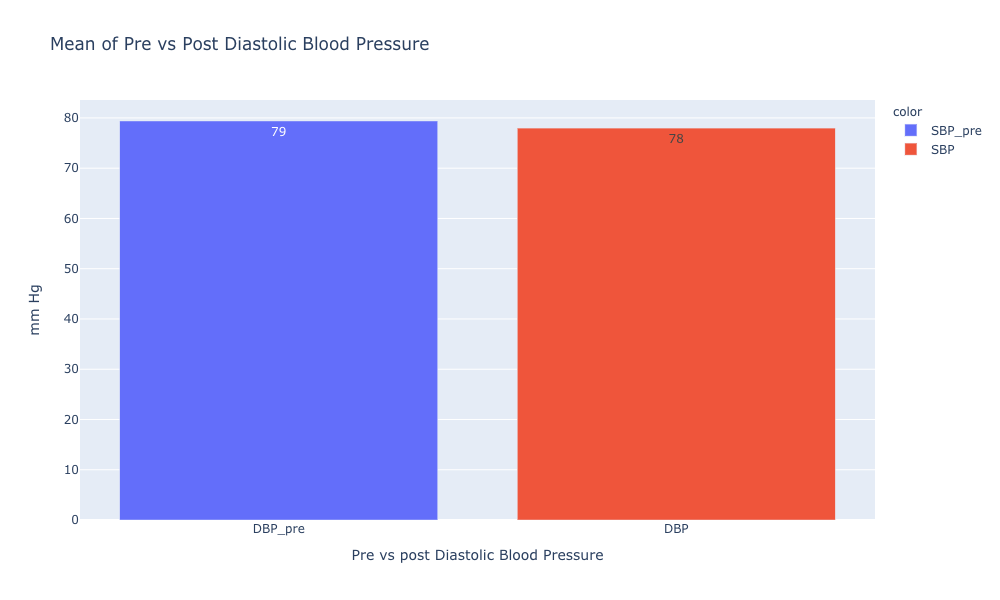

In [409]:
fig32 = px.bar(dbp_df.mean().round(2), title='Mean of Pre vs Post Diastolic Blood Pressure', height=600, width=1000,
               color=sbp_df.columns,text=dbp_df.median().round(2),
               labels={'index':'Pre vs post Diastolic Blood Pressure','value':'mm Hg'})
fig32.show(renderer='png', width=1000, height=600)

## Correlation Matrix between all the parameters in the dataframe

In [293]:
df_final_new = df_final.copy()

In [294]:
#Changing the necessary string columns into categorical columns
for column in df_final_new[['site','CUPE','location','spesi','biomarkers','dyspnea','lytics_contra','hx_pe','hx_dvt','cur_dvt','icu_stay','dyspnea_30']].columns:
    df_final_new[column] = df_final_new[column].astype('category').cat.codes +1

In [295]:
df_final_new['T24'] = np.where(((df_final_new['T20'] == 0) & (df_final_new['missing'] == 0)),1,0)
df_final_new = df_final_new.drop('missing',axis=1)

### Cleaning Data 

In [296]:
df_final_new =  df_final_new.drop(df_final_new[df_final_new['cath_time'] <0].index, axis=0)

In [297]:
missing_times_rows = list(df_final_new[df_final_new.isnull().sum(axis=1) >= 10].index)
df_final_new.drop(missing_times_rows, inplace=True)

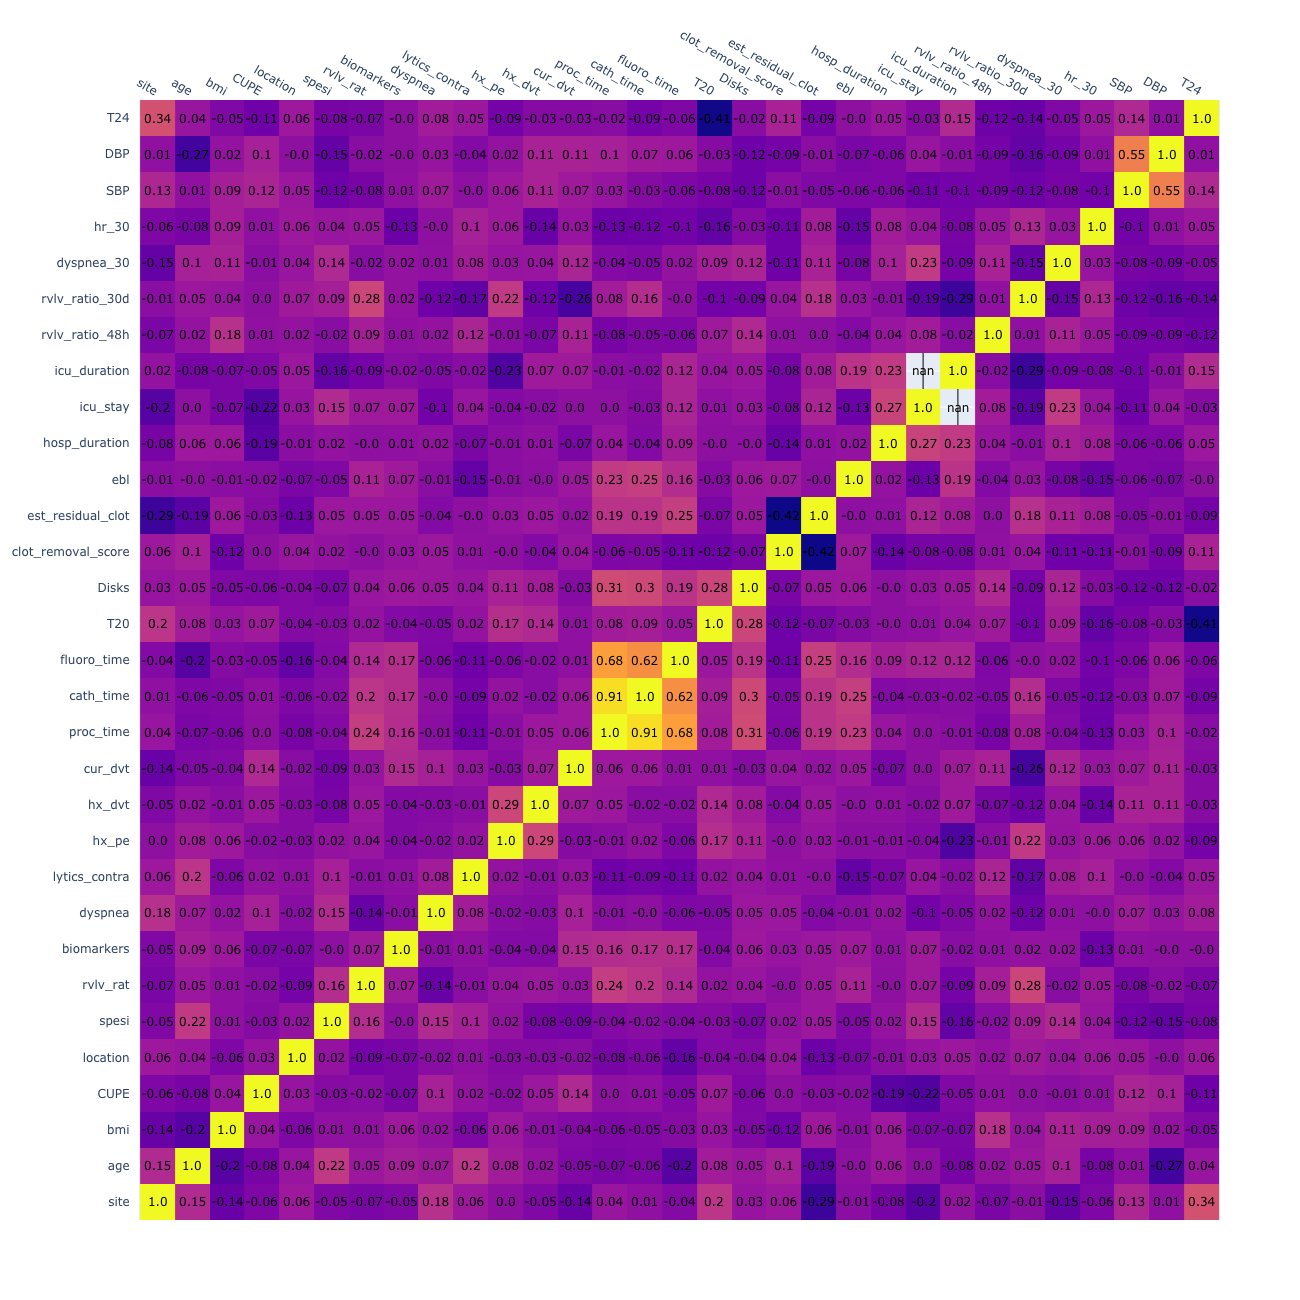

In [369]:
corr2 = df_final_new.corr().round(2)
corr2
fig33 = ff.create_annotated_heatmap(corr2.values,x=[x for x in corr2.columns], y=[y for y in corr2.index])
fig33.update_layout(height=1300, width=1300)
fig33.show(renderer='png', height=1300, width=1300)

### Esimated Blood loss, estimated residual clot and clot removal score by catheter

In [299]:
sub_cath_df = df_final[['ebl','est_residual_clot','clot_removal_score','T20','missing','Disks']]

In [300]:
sub_cath_df['T24'] = np.where(((sub_cath_df['T20'] == 0) & (sub_cath_df['missing'] == 0)),1,0)
sub_cath_df['Catheter'] = sub_cath_df['T20']

In [301]:
sub_cath_df['Catheter'].loc[(sub_cath_df['T20'] == 1) & (sub_cath_df['Disks'] == 0)] = 'T20'
sub_cath_df['Catheter'].loc[(sub_cath_df['T20'] == 1) & (sub_cath_df['Disks'] == 1)] = 'T20 and Disks'
sub_cath_df['Catheter'].loc[(sub_cath_df['T24'] == 1) & (sub_cath_df['Disks'] == 0)] = 'T24'
sub_cath_df['Catheter'].loc[(sub_cath_df['T24'] == 1) & (sub_cath_df['Disks'] == 1)] = 'T24 and Disks'

In [302]:
sub_cath_df = sub_cath_df[sub_cath_df['missing']==0].drop(['missing', 'T20','Disks','T24'],axis=1)

### Esimated Blood loss by catheter

In [303]:
ebl_cath_df = sub_cath_df[['Catheter','ebl']]
ebl_cath_df

Catheter    ebl
0              T20  300.0
3              T24  395.0
4              T24  150.0
6              T20    NaN
7    T20 and Disks  720.0
..             ...    ...
317            T24   10.0
318  T20 and Disks  300.0
321            T20  100.0
323            T20  200.0
324            T20   40.0

[196 rows x 2 columns]

In [304]:
#Creating a df to summarize estimated blood loss by catheter
ebl_cath_df1 = ebl_cath_df.groupby(['Catheter'])['ebl'].agg('median')
ebl_cath_df2 = ebl_cath_df.Catheter.value_counts()

In [305]:
agg_ebl_cath_df = pd.DataFrame({'Counts':ebl_cath_df1,'Percentage':ebl_cath_df2})
agg_ebl_cath_df = agg_ebl_cath_df.reset_index()
agg_ebl_cath_df.columns = ['Catheter','Average Blood Loss','Number of Patients']
agg_ebl_cath_df

Catheter  Average Blood Loss  Number of Patients
0            T20               200.0                 112
1  T20 and Disks               300.0                  27
2            T24               285.0                  52
3  T24 and Disks               500.0                   5

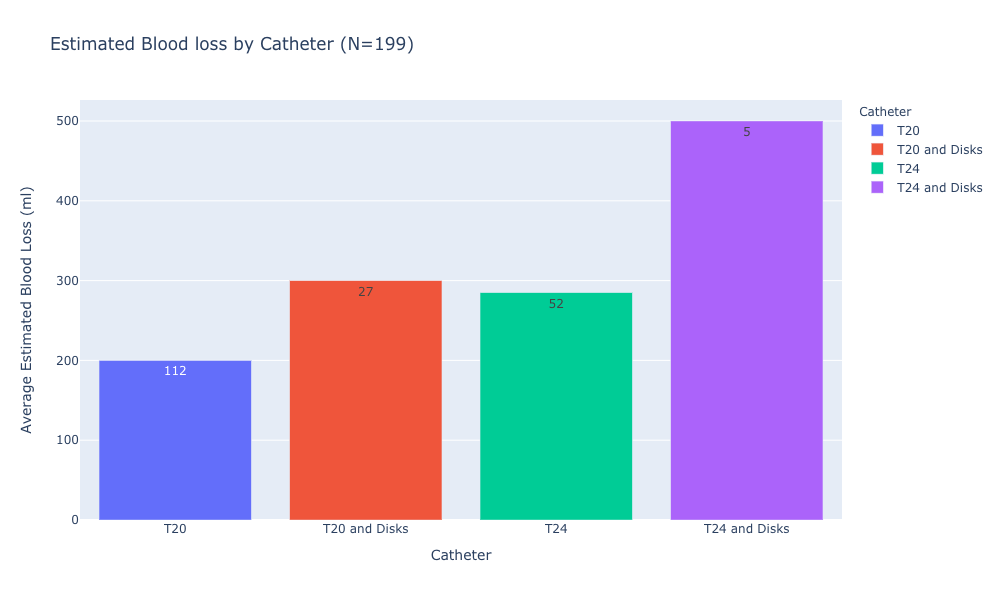

In [410]:
fig34 = px.bar(agg_ebl_cath_df, x="Catheter", y="Average Blood Loss",title='Estimated Blood loss by Catheter (N=199)',
               color='Catheter',labels={'Average Blood Loss':'Average Estimated Blood Loss (ml)'}, 
               text='Number of Patients', height=600, width=1000)

# show the image
fig34.show(renderer='png', width=1000, height=600)

### Estimated Residual clot by catheter usage

In [307]:
erc_cath_df = sub_cath_df[['Catheter','est_residual_clot']]

In [308]:
#Creating a df to summarize Estimated Residual Clot by catheter
erc_cath_df1 = erc_cath_df.groupby(['Catheter'])['est_residual_clot'].agg('median')
erc_cath_df2 = erc_cath_df.Catheter.value_counts()

In [309]:
agg_erc_cath_df = pd.DataFrame({'Counts':erc_cath_df1,'Percentage':erc_cath_df2})
agg_erc_cath_df = agg_erc_cath_df.reset_index()
agg_erc_cath_df.columns = ['Catheter','Estimated Residual Clot','Number of Patients']
agg_erc_cath_df

Catheter  Estimated Residual Clot  Number of Patients
0            T20                     20.0                 112
1  T20 and Disks                     22.5                  27
2            T24                     15.0                  52
3  T24 and Disks                     35.0                   5

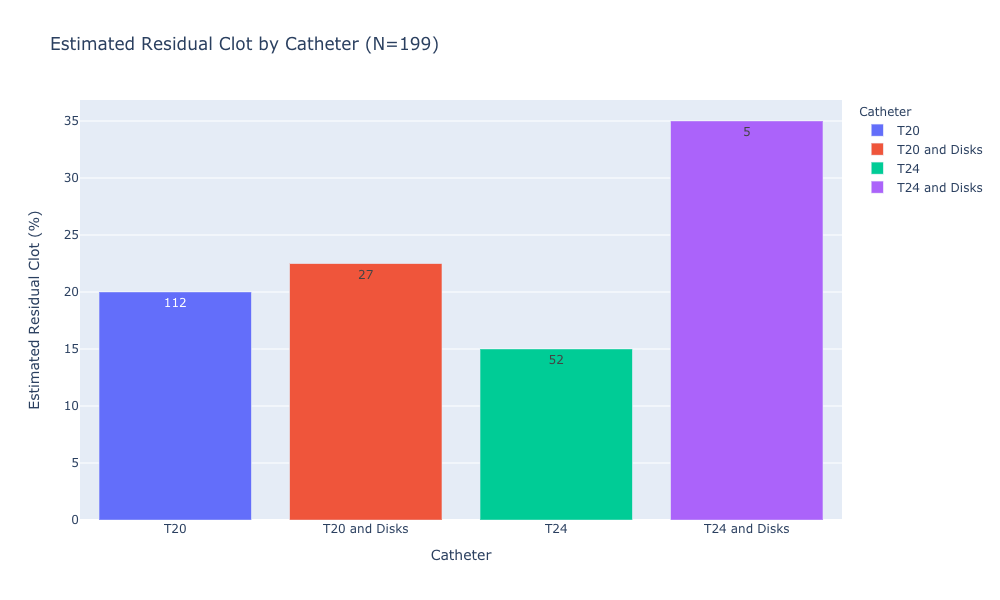

In [411]:
fig35 = px.bar(agg_erc_cath_df, x="Catheter", y="Estimated Residual Clot",
               title='Estimated Residual Clot by Catheter (N=199)',
               color='Catheter',labels={'Estimated Residual Clot':'Estimated Residual Clot (%)'}, 
               text='Number of Patients', height=600, width=1000)

# show the image
fig35.show(renderer='png', width=1000, height=600)

### Clot Removal Score by catheter usage

In [311]:
crs_cath_df = sub_cath_df[['Catheter','clot_removal_score']]

In [312]:
#Creating a df to summarize Estimated Residual Clot by catheter
crs_cath_df1 = crs_cath_df.groupby(['Catheter'])['clot_removal_score'].agg('median')
crs_cath_df2 = crs_cath_df.Catheter.value_counts()

In [313]:
agg_crs_cath_df = pd.DataFrame({'Counts':crs_cath_df1,'Percentage':crs_cath_df2})
agg_crs_cath_df = agg_crs_cath_df.reset_index()
agg_crs_cath_df.columns = ['Catheter','Clot Removal Score','Number of Patients']
agg_crs_cath_df

Catheter  Clot Removal Score  Number of Patients
0            T20                 3.0                 112
1  T20 and Disks                 3.0                  27
2            T24                 4.0                  52
3  T24 and Disks                 3.0                   5

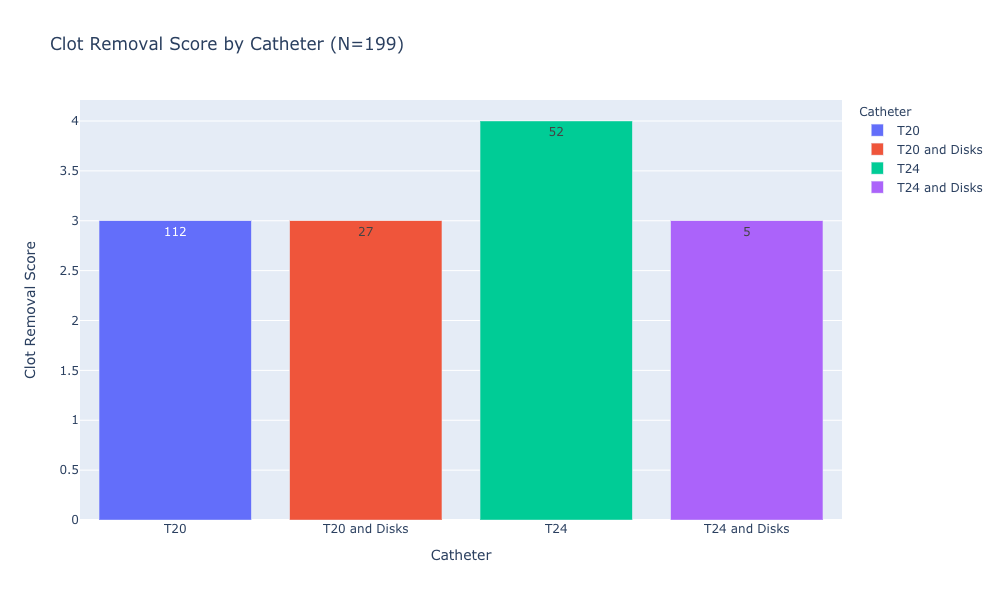

In [412]:
fig36 = px.bar(agg_crs_cath_df, x="Catheter", y="Clot Removal Score",
               title='Clot Removal Score by Catheter (N=199)',
               color='Catheter',labels={'Estimated Residual Clot':'Estimated Residual Clot (%)'}, 
               text='Number of Patients', height=600, width=1000)

# show the image
fig36.show(renderer='png', width=1000, height=600)

In [315]:
html_string1 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h1 style="color:purple;font-size:28px;text-align:center;">Inari Medical Clinical Insights Assignment - Akshaya Sundaramurthy </h1>
        <h1 style="font-size:24px;">1. Are there any association between clot location and procedural characteristics?</h1>

        <!-- *** Section 1 *** --->
        <h2 style="font-size:18px;">a. Patients per Clot Location</h2>
     </body>
</html>'''

html_string2 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">b. Clot Location vs Catheters</h2>
        <p style="font-size:16px;">The T20 catheter was mostly used irrespective of where the clot was located in patients. On average, 59% of cases used the T20 catheter and in 15% of cases, disk catheters were employed. </p>

        <p style="font-size:16px;">The median time taken to perform any procedure (fluoro_time, cath_time, proc_time) was shorter for subjects with unilateral clot. Subjects with bilateral and saddle clots approximately had the same median times for fluoro_time, cath_time and pro_time.</p>
        
    </body>
</html>'''

html_string3 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">c. Clot Location vs Clot Removal Times</h2>
        <p style="font-size:16px;">From the correlation matrix, it looks like there is no relationship between clot location and the times taken to perform the clot removal. The correlation matrix also shows the high correlation between proc_time and cath_time (r = 0.91). The correlation coefficient (r) between cath_time and fluoro_time  and proc_time and fluoro_time is 0.62 and 0.68 respectively.</p>

        <p style="font-size:16px;">From the pair plot we can understand that as the time taken to perform catheterization increases, the overall procedure time also increases. For fluoro_time vs cath_time and fluro_time vs proc_time, the relationship is not as linear as cath_time vs proc_time but, it does appear like the proc_time and cath_time increases when fluoro_time increases.</p>
        
    </body>
</html>'''


html_string4 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    
    </head>
    <body>
        <h1 style="font-size:24px;">2. Are any baseline or procedural characteristics associated with one another or with outcomes measures?</h1>

        <!-- *** Section 1 *** --->
        <h2 style="font-size:18px;">Age Distribustion of Patients</h2>
        
    </body>
</html>'''

html_string5 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Relationship between Clot Removal times depending on age</h2>
        
        <p style="font-size:16px;">The median times taken for clot removal is much lower for people in their 20s compared to other age groups but only 2% (7) of patients belong in this age group. </p>
        <p style="font-size:16px;">The median times taken for clot removal in their 30s is much higher than in other age groups but only 5% (15) of patients belong in this age group.</p>
        <p style="font-size:16px;">Age (Years):  61.31±14.05</p
    </body>
</html>'''

html_string6 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>

    </head>
    <body>
        <h2 style="font-size:18px;">Relationship between Clot Removal times depending on BMI</h2>
        <p style="font-size:16px;">There was no relationship between BMI and clot removal times.</p>
        <p style="font-size:16px;">The patients are mostly in the obese category.</p>
        <p style="font-size:16px;">BMI (kg/m^2 ): 34.80± 8.48 <br> Normal BMI range: 18.5 to 24.9 kg/m^2</p>
        
    </body>
</html>'''

html_string7 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Does Hospital duration depend on age?</h2>

    </body>
</html>'''
        
html_string8 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Does ICU duration depend on age?</h2>
    </body>
</html>'''

html_string9 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">How many patients have history of Pulmonary Embolism or history/current Deep Vein Thrombosis?</h2>
        <p style="font-size:16px;">65% of patients currently have Deep vein Thrombosis which means that these patients might need another clot removal procedure to be done</p>
        <p style="font-size:16px;">From the provided dataset, the reoccurence rate of Pulmonary Embolism was 9%</p>
        
    </body>
</html>'''

html_string10 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body> 
        <h2 style="font-size:18px;">Frequency of Clot Removal Scores in patients</h2>
        <p style="font-size:16px;">81% of patients had a huge portion of their clot removed and only one subject (0.35%) had no clot removal.</p>
    
    </body>
</html>'''

html_string11 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">What is the Estimated Residual Clot% remaining in patients?</h2>
        <p style="font-size:16px;">In 73% of patients, more than 70% of the clot was removed</p>

    </body>
</html>'''

html_string12 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">How much is the Estimated Blood loss in patients?</h2>
        <p style="font-size:16px;">24% of people lost less than 100ml of blood</p>
        <p style="font-size:16px;">64% of people lost between 100 and 500ml of blood</p>
        <p style="font-size:16px;">Only 1% of people lost more than 1000ml of blood</p>

        <p style="font-size:16px;">Note: One of the entries was 7500 which might be due to a data entry error. If yes, then fewer than 1% of patients lost over 1000ml of blood</p>
        
    </body>
</html>'''
        
html_string13 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">How many patients are at intermediate and high risk?</h2>
         <p style="font-size:16px;">6% of patients were at high risk</p>
        
    </body>
</html>'''

html_string14 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">How many patients have biomarkers?</h2>
        <p style="font-size:16px;">96% of the subjects had biomarkers </p>
        
    </body>
</html>'''    

html_string15 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">What is the spesi score in patients?</h2>
        <p style="font-size:16px;">14% of subjects were healthy with a score of 0 and 69% subjects had a score within 2.</p>

        
    </body>
</html>'''

html_string16 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">How many patients are contraindicated for lytics?</h2>
        <p style="font-size:16px;">38% had contraindications to lytics </p>
    </body>
</html>'''   

html_string17 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Comparison of Dyspnea before procedure and at 30 days after procedure</h2>
        <p style="font-size:16px;">Dyspnea scores improved significantly from 2.33±1.52 at baseline to 0.63±0.96 at 30 days</p>
        <p style="font-size:16px;">Considering dyspnea scores of 3 and 4 as severe cases, percent of patients with severe dyspnea improved from 57% at baseline to 7% at 30 days</p>
        <p style="font-size:16px;">The number of healthy subjects improved from 20% to 60%</p>
        
    </body>
</html>'''

html_string18 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">RV/LV Ratio at Baseline vs 48 hours after procedure</h2>
        <p style="font-size:16px;">The Mean of RV/LV ratio at 48 hours is much lesser compared to the mean of RV/LV at baseline*.</p>
        <p style="font-size:16px;">At risk RV/LV ratio : > 0.9</p>
        <p style="font-size:12px;">Note: The Median scores are marked on the bars</p>
        
    </body>
</html>'''   

html_string19 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">RV/LV Ratio at Baseline vs 48 hours after procedure vs 30 days after procedure</h2>
        <p style="font-size:16px;">The Mean of RV/LV ratio at 30 days is much lesser compared to RV/LV ratio at 48 hours which is lesser than RV/LV ratio at baseline</p>
        <p style="font-size:16px;">At risk RV/LV ratio : > 0.9</p>
        <p style="font-size:12px;">Note: The Median scores are marked on the bars</p>

    </body>
</html>'''  

html_string20 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">RV/LV Ratio at Baseline vs 30 days after procedure</h2>
        <p style="font-size:16px;">The Mean of RV/LV ratio at 30 days is much lesser compared to RV/LV ratio at baseline*. The RV/LV ratio > 0.94,5 is considered at risk so most of the patients fell in the not at-risk category after the procedure</p>
        <p style="font-size:16px;">At risk RV/LV ratio : > 0.9</p>
        <p style="font-size:12px;">Note: The Median scores are marked on the bars</p>
       
    </body>
</html>'''  

html_string21 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Heart Rate before vs after procedure</h2>
        <p style="font-size:16px;">The mean post-procedure heart rate was lesser than the pre-procedure heart rate and most of the patients had a healthier heart rate proving that most patients had healthier heart rate after the procedure.</p> 
        <p style="font-size:16px;">Normal Heart Rate: 81.8±19.6</p>
        <p style="font-size:12px;">Note: The Median scores are marked on the bars</p>
        
    </body>
</html>'''

html_string22 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Heart Rate before vs after procedure vs 30 days</h2>
        <p style="font-size:16px;">The mean heart rate at 30 days was lesser than post-procedure heart rate which was lesser than the pre-procedure heart rate proving that most of the patients had a healthier heart rate after the procedure.</p> 
        <p style="font-size:16px;">Normal Heart Rate: 81.8±19.6</p>
        <p style="font-size:12px;">Note: The Median scores are marked on the bars</p>
        
    </body>
</html>'''

html_string23 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Systolic Blood Pressure before vs after procedure</h2>
        <p style="font-size:16px;">There was a slight increase in the mean systolic blood pressure after the procedure. The mean blood pressure of the patients before and after the procedure was in elevated range.</p> 
        <p style="font-size:16px;">Normal Systolic Blood pressure: <120</p>
        <p style="font-size:16px;">Elevated Systolic Blood pressure: 120-129</p>
        <p style="font-size:12px;">Note: The Median scores are marked on the bars</p>

    </body>
</html>'''

html_string24 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Diastolic Blood Pressure before vs after procedure</h2>
        <p style="font-size:16px;">There was a slight decrease in the mean diastolic blood pressure after the procedure. The mean blood pressure of patients before and after the procedure was in the normal range.</p> 
        <p style="font-size:16px;">Normal Diastolic Blood pressure: <80</p>
        <p style="font-size:12px;">Note: The Median scores are marked on the bars</p>

    </body>
</html>'''

html_string25 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">Correlation Matrix between all parameters</h2>
        
    </body>
</html>'''

html_string26 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">What is the estimated blood loss per catheter?</h2>
        <p style="font-size:16px;">In patients where T24 and disks were used, there was maximum blood loss.The median blood loss was 500ml.</p>
        <p style="font-size:16px;">T20 and disk usage led to a median blood loss of 300ml.</p 
        <p style="font-size:16px;">The median blood loss using T24 was a little higher compared to T20 catheter.</p>
      
    </body>
</html>'''

html_string27 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">What is the Estimated Residual clot per catheter?</h2>
        <p style="font-size:16px;">Residual clot% was higher in cases were T24 and disks were used. This might be because disks were employed only in difficult cases where T20/T24 catheter were not successful in retrieving clots.</p>
        <p style="font-size:16px;">The median estimated residual clot% for T24 is 15% compared to T20 at 20%.</p>
        
    </body>
</html>'''

html_string28 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">What is the Clot Removal Score per catheter?</h2>
        <p style="font-size:16px;">In cases where T24 was used, the catheter retrieved a huge load of the clot with a median score of 4.</p>

    </body>
</html>'''

html_string29 = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
    </head>
    <body>
        <h2 style="font-size:18px;">References</h2>
        <p style="font-size:16px;">1. Avram, R., Tison, G. H., Aschbacher, K., Kuhar, P., Vittinghoff, E., Butzner, M., Runge, R., Wu, N., Pletcher, M. J., Marcus, G. M., & Olgin, J. (2019). Real-world heart rate norms in the Health eHeart study. Npj Digital Medicine, 2(1). https://doi.org/10.1038/s41746-019-0134-9</p>
        <p style="font-size:16px;">2. American Heart Association. (2021). Understanding Blood Pressure Readings. Www.heart.org. https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings</p>
        <p style="font-size:16px;">3. Basile, J. N. (2002). Systolic blood pressure. BMJ : British Medical Journal, 325(7370), 917–918. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1124431/</p>
        <p style="font-size:16px;">4. AMGRad - RV/LV Ratio. (n.d.). Amgrad.org. Retrieved July 27, 2021, from https://amgrad.org/reference/rvlv.pl</p>
        <p style="font-size:16px;">5. Kumamaru, K. K., George, E., Ghosh, N., Quesada, C. G., Wake, N., Gerhard-Herman, M., & Rybicki, F. J. (2016). Normal ventricular diameter ratio on CT provides adequate assessment for critical right ventricular strain among patients with acute pulmonary embolism. The International Journal of Cardiovascular Imaging, 32(7), 1153–1161. https://doi.org/10.1007/s10554-016-0887-z</p>
        <p style="font-size:16px;">6. Weir, C. B., & Jan, A. (2020). BMI Classification Percentile And Cut Off Points. PubMed; StatPearls Publishing. https://www.ncbi.nlm.nih.gov/books/NBK541070/</p>

    </body>
</html>'''


In [316]:
with open('Inari_assignment_AS.html', 'w') as f:
    f.write(html_string1)
    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string2)
    f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string3)
    f.write(subfig1.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig4.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string4)
    f.write(fig5.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string5)
    f.write(fig6.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(subfig2.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string6)
    f.write(fig7.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(subfig3.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string7)
    f.write(fig8.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string8)
    f.write(fig9.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string9)
    f.write(fig10.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string10) 
    f.write(fig11.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string11)
    f.write(fig12.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string12)
    f.write(fig13.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string13)
    f.write(fig14.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string14)
    f.write(fig15.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string15)
    f.write(fig16.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string16)
    f.write(fig17.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string17)
    f.write(fig18.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string18)
    f.write(fig19.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig20.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string19)
    f.write(fig21.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig22.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string20)
    f.write(fig23.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig24.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string21)
    f.write(fig25.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig26.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string22)
    f.write(fig27.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig28.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string23)
    f.write(fig29.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig30.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string24)
    f.write(fig31.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig32.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string25)
    f.write(fig33.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string26)
    f.write(fig34.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string27)
    f.write(fig35.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string28)
    f.write(fig36.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(html_string29)